<center>
<p><img src="files/figs/nbalogo.jpg"></p>
<h1 style="font-size:50px">Analyzing and Predicting NBA Most Valuable Player Award</h1>
<h4 style="font-size:20px">Mary Hood, Manpreet Sidhu, Alex Rothman</h4>
<hr>

<center>
<h1 style="font-size:30px">Introduction</h1>

The National Basketball Association (NBA) is the leading professional basketball league in North America. From October to June, millions of viewers will be watching games on TV or in-person, cheering on their favorite players and/or teams. The league consists of 30 teams and is divided into two conferences, the Eastern and the Western conference. Each team plays 82 games during the regular season. After the regular season is over, teams compete in playoffs in order to qualify for the NBA Finals. The NBA Finals are when the winning teams for both conferences faceoff in a best-of-seven game series for the title of NBA champions and for the Larry O'Brien Championship Trophy. After the series is over, the NBA hosts an awards ceremony celebrating the accomplishments of its players.

The finalists for the NBA awards are announced during the NBA Finals and then revealed during the ceremony weeks later. The NBA awards are given out based upon skill and performance, but also for fan favorite moments or highlights. Every year viewers tune in to find out if their favorite players won awards like Rookie of the Year (ROY), Defensive Player of the Year (DPOY), and most importantly Most Valuable Player (MVP). Our project will be analyzing and predicting the result of the MVP award. The MVP award is given to the best performing player of the season. It is important to note that the award is given out based upon regular season statistics only. This means that a player's playoff and potential NBA Finals performance should have no impact on their odds of winning the award. The MVP is selected by a panel of sportswriters and broadcasters who each vote for their top 5 selections. Each successive placing has a lower weighting in overall points earned. In 2010, the NBA also began adding in a fan vote that gets factored into a player's overall points earned. The player with the most points wins the award. 
    
Before we attempted to predict the winner of the MVP award for this year, we decided to look into the statistics of all players and the MVP front-runner candidates of the 2018-2019 season. This allowed us to gain insight into what factors are important during the selection of MVP candidates. The winner of the MVP award last year was Giannis Antetokounmpo, a forward on the Milwaukee Bucks, who was in his sixth season in the NBA.     
<br> 
<figure>
<img src="files/figs/Giannis.jpg">
<center>
<figcaption>Giannis Antetokounmpo holding the Maurice Podoloff MVP Trophy</figcaption>
</center>
</figure> 

<center>
<h1 style="font-size:28px">Getting Started With The Data</h1>

We used Basketball-Reference.com as the source of our statistical datasets. It is a branch of Sports Reference, LLC, which provides statistical datasets for popular American sports. We decided to use this website over other sources because it is easy to comprehend and incredibly user friendly. It enabled us to select specific statistics and ignore statistics that were completely irrelevant to us.

In [7]:
# Imports any necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from sklearn import utils
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_columns', 60)

<center>
<h1 style="font-size:24px">2018-2019 NBA Season Stats</h1>
</center>
    The following code snippet populates a Pandas dataframe with statistics on all NBA players during the 2018-2019 season. The nba_stats dataframe will hold the statistics from the Basketball Reference "per game" counting statistics dataset found <a href="https://www.basketball-reference.com/leagues/NBA_2019_per_game.html">here</a> and from the "advanced" player statistics dataset found <a href="https://www.basketball-reference.com/leagues/NBA_2019_advanced.html">here</a>. The two datasets are then merged together using an outer merge so that the dataframe will contain both the "advanced" and "per game" statistics of every player that season. Finally, we added a dataset that contains the standings for every team that can be found <a href="https://www.basketball-reference.com/leagues/NBA_2019_standings.html#all_expanded_standings">here</a>. This allowed us to add the team wins, loses, and winning percentage to every player entry of the dataframe.

In [8]:
# Reads the per game player statistics dataset in as nba_stats_regular
nba_stats_regular = pd.read_csv("18_19_stats.csv")
nba_stats_regular = nba_stats_regular.drop(columns = ["Rk"])

# Reads the advanced player statistics dataset in as nba_stats_advanced
nba_stats_advanced = pd.read_csv("18_19_stats_advanced.csv")
nba_stats_advanced = nba_stats_advanced.drop(columns = ["Rk"])

# Reads the team statistics dataset in as nba_team_stats
nba_stats_teams = pd.read_csv("18_19_team_standings.csv")
nba_stats_teams = nba_stats_teams.drop(columns = ["Rk"])

# General helper function to clean up the formatting of the player name column
# This will be used throughout our code
def clean_name_column(dataframe):
    for i, row in dataframe.iterrows():
        player = row.Player
        name_split = player.split('\\')
        player_name = name_split[0]
        dataframe.at[i, 'Player'] = player_name

# Clean the player columns for the relevant datasets
clean_name_column(nba_stats_regular)
clean_name_column(nba_stats_advanced)

# Merge the per game and advanced player statistics together. Drops any duplicate columns.
nba_stats = nba_stats_regular.merge(right = nba_stats_advanced, how = 'outer', suffixes = ('', '_repeat'), 
                                    left_index = True, right_index = True)

# Drop any repeated columns (they end in _repeat)
nba_stats = nba_stats[nba_stats.columns.drop(list(nba_stats.filter(regex = '_repeat')))]

# Sort the nba_stats dataframe by points
nba_stats = nba_stats.sort_values(by = "PTS", ascending = False)

# Add a wins, loses, and win percentage column to nba_stats_teams
nba_stats_teams['W'] = np.nan
nba_stats_teams['L'] = np.nan
nba_stats_teams['W%'] = np.nan

# Split nba_stats_teams up so that there is a column for wins, loses, and winning percentage for each time
for i, row in nba_stats_teams.iterrows():
    standings = row.Overall
    standings_split = standings.split('-')
    wins = int(standings_split[0])
    loses = int(standings_split[1])
    win_percentage = (wins / 82) * 100 #82 the number of regular season games
    nba_stats_teams.at[i, 'W'] = wins
    nba_stats_teams.at[i, 'L'] = loses
    nba_stats_teams.at[i, 'W%'] = win_percentage
    
# Remove the Overall column in nba_stats_teams
nba_stats_teams = nba_stats_teams.drop(columns = ["Overall"])

# Populate each player entry with their team's wins, loses, and win percentage
nba_stats['W'] = np.nan
nba_stats['L'] = np.nan
nba_stats['W%'] = np.nan
for i, row in nba_stats_teams.iterrows():
    for index in nba_stats.index[nba_stats['Tm'] == row['Tm']]:
        nba_stats.at[index, 'W'] = row['W']
        nba_stats.at[index, 'L'] = row['L']
        nba_stats.at[index, 'W%'] = row['W%']

nba_stats = nba_stats.reset_index()
nba_stats = nba_stats.drop(columns = ["index"])
nba_stats.head(30)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,W,L,W%
0,James Harden,PG,29,HOU,78,78,36.8,10.8,24.5,0.442,4.8,13.2,0.368,6.0,11.3,0.528,0.541,9.7,11.0,0.879,0.8,5.8,6.6,7.5,2.0,0.7,5.0,3.1,36.1,30.6,0.616,0.539,0.449,2.5,17.8,10.0,39.5,2.7,1.7,14.5,40.5,11.4,3.8,15.2,0.254,10.5,1.1,11.7,9.9,53.0,29.0,64.634146
1,Paul George,SF,28,OKC,77,77,36.9,9.2,21.0,0.438,3.8,9.8,0.386,5.4,11.1,0.484,0.529,5.9,7.0,0.839,1.4,6.8,8.2,4.1,2.2,0.4,2.7,2.8,28.0,23.3,0.583,0.469,0.335,3.7,19.6,11.4,17.7,2.8,1.0,10.0,29.5,7.0,4.9,11.9,0.201,4.7,0.7,5.5,5.3,49.0,33.0,59.756098
2,Giannis Antetokounmpo,PF,24,MIL,72,72,32.8,10.0,17.3,0.578,0.7,2.8,0.256,9.3,14.5,0.641,0.599,6.9,9.5,0.729,2.2,10.3,12.5,5.9,1.3,1.5,3.7,3.2,27.7,30.9,0.644,0.163,0.550,7.3,30.0,19.3,30.3,1.8,3.9,14.8,32.3,8.9,5.5,14.4,0.292,5.7,5.0,10.8,7.6,60.0,22.0,73.170732
3,Joel Embiid,C,24,PHI,64,64,33.7,9.1,18.7,0.484,1.2,4.1,0.300,7.8,14.6,0.535,0.517,8.2,10.1,0.804,2.5,11.1,13.6,3.7,0.7,1.9,3.5,3.3,27.5,26.1,0.593,0.219,0.541,8.1,34.0,21.4,18.4,1.0,4.4,13.2,33.3,4.9,3.8,8.7,0.194,2.0,2.1,4.1,3.3,51.0,31.0,62.195122
4,LeBron James,SF,34,LAL,55,55,35.2,10.1,19.9,0.510,2.0,5.9,0.339,8.1,14.0,0.582,0.560,5.1,7.6,0.665,1.0,7.4,8.5,8.3,1.3,0.6,3.6,1.7,27.4,25.6,0.588,0.299,0.382,3.1,21.3,12.4,39.4,1.7,1.4,13.3,31.6,4.7,2.6,7.2,0.179,6.2,1.9,8.1,4.9,37.0,45.0,45.121951
5,Stephen Curry,PG,30,GSW,69,69,33.8,9.2,19.4,0.472,5.1,11.7,0.437,4.0,7.7,0.525,0.604,3.8,4.2,0.916,0.7,4.7,5.3,5.2,1.3,0.4,2.8,2.4,27.3,24.4,0.641,0.604,0.214,2.2,14.2,8.4,24.2,1.9,0.9,11.6,30.4,7.2,2.5,9.7,0.199,7.7,-1.4,6.3,4.9,57.0,25.0,69.512195
6,Devin Booker,SG,22,PHO,64,64,35.0,9.2,19.6,0.467,2.1,6.5,0.326,7.0,13.1,0.536,0.521,6.1,7.1,0.866,0.6,3.5,4.1,6.8,0.9,0.2,4.1,3.1,26.6,20.2,0.584,0.330,0.362,1.9,11.3,6.5,34.1,1.2,0.5,15.4,32.9,3.3,0.3,3.5,0.076,3.8,-3.0,0.8,1.6,19.0,63.0,23.170732
7,Kawhi Leonard,SF,27,TOR,60,60,34.0,9.3,18.8,0.496,1.9,5.0,0.371,7.5,13.8,0.542,0.546,6.1,7.1,0.854,1.3,6.0,7.3,3.3,1.8,0.4,2.0,1.5,26.6,25.8,0.606,0.267,0.377,4.2,18.6,11.6,16.4,2.5,1.0,8.4,30.3,6.1,3.4,9.5,0.224,4.3,0.7,5.0,3.6,58.0,24.0,70.731707
8,Kevin Durant,SF,30,GSW,78,78,34.6,9.2,17.7,0.521,1.8,5.0,0.353,7.5,12.8,0.587,0.571,5.7,6.5,0.885,0.4,5.9,6.4,5.9,0.7,1.1,2.9,2.0,26.0,24.2,0.631,0.281,0.366,1.4,17.5,9.8,26.2,1.0,2.6,12.3,29.0,8.6,2.9,11.5,0.204,4.2,0.1,4.3,4.3,57.0,25.0,69.512195
9,Anthony Davis,C,25,NOP,56,56,33.0,9.5,18.3,0.517,0.9,2.6,0.331,8.6,15.7,0.547,0.540,6.1,7.7,0.794,3.1,8.9,12.0,3.9,1.6,2.4,2.0,2.4,25.9,30.3,0.597,0.141,0.422,9.9,27.5,18.8,19.0,2.2,6.0,8.4,29.5,6.4,3.1,9.5,0.247,4.7,3.9,8.5,4.9,33.0,49.0,40.243902


There is a wealth of data on every NBA player from the 2018-2019 season stored within the dataframe. Not all of the statistics we have stored will be used in our analysis or predictions. However, we have decided to keep all of the information for any viewers interested in seeing other relevant player statistics. Listed below are what each of the abbreviated column names stand for. The definitions of any columns used during our analysis/predictions will be restated when utilized; however, definitions for all of these terms can be found in the glossaries of each dataset linked above. Additionally, the NBA has a glossary defining any terminology they use when it comes to statistics that can be found <a href="https://stats.nba.com/help/glossary/">here</a>.

<ul style="list-style-type:none;">   
<li>Pos -- Position</li>
<li>Age -- Age of Player at the start of February 1st of that season.</li>
<li>Tm -- Team</li>
<li>G -- Games</li>
<li>GS -- Games Started</li>
<li>MP -- Minutes Played Per Game</li>
<li>FG -- Field Goals Per Game</li>
<li>FGA -- Field Goal Attempts Per Game</li>
<li>FG% -- Field Goal Percentage</li>
<li>3P -- 3-Point Field Goals Per Game</li>
<li>3PA -- 3-Point Field Goal Attempts Per Game</li>
<li>3P% -- FG% on 3-Pt FGAs</li>
<li>2P -- 2-Point Field Goals Per Game</li>
<li>2PA -- 2-Point Field Goal Attempts Per Game</li>
<li>2P% -- FG% on 2-Pt FGAs</li>
<li>eFG% -- Effective Field Goal Percentage</li>
<li>FT -- Free Throws Per Game</li>
<li>FTA -- Free Throw Attempts Per Game</li>
<li>FT% -- Free Throw Percentage</li>
<li>ORB -- Offensive Rebounds Per Game</li>
<li>DRB -- Defensive Rebounds Per Game</li>
<li>TRB -- Total Rebounds Per Game</li>
<li>AST -- Assists Per Game</li>
<li>STL -- Steals Per Game</li>
<li>BLK -- Blocks Per Game</li>
<li>TOV -- Turnovers Per Game</li>
<li>PF -- Personal Fouls Per Game</li>
<li>PTS -- Points Per Game</li>   
<li>PER -- Player Efficiency Rating</li>
<li>TS% -- True Shooting Percentage</li>
<li>3PAr -- 3-Point Attempt Rate</li>
<li>FTr -- Free Throw Attempt Rate</li>
<li>ORB% -- Offensive Rebound Percentage</li>
<li>DRB% -- Defensive Rebound Percentage</li>
<li>TRB% -- Total Rebound Percentage</li>
<li>AST% -- Assist Percentage</li>
<li>STL% -- Steal Percentage</li>
<li>BLK% -- Block Percentage</li>
<li>TOV% -- Turnover Percentage</li>
<li>USG% -- Usage Percentage</li>
<li>OWS -- Offensive Win Shares</li>
<li>DWS -- Defensive Win Shares</li>
<li>WS -- Win Shares</li>
<li>WS/48 -- Win Shares Per 48 Minutes</li>
<li>OBPM -- Offensive Box Plus/Minus</li>
<li>DBPM -- Defensive Box Plus/Minus</li>
<li>BPM -- Box Plus/Minus</li>
<li>VORP -- Value over Replacement Player</li>  
</ul>

<center>
<h1 style="font-size:28px">Data Visualization</h1>
Our dataframe contains a lot of statistics, which is why we have decided to visualize the relationships between certain datapoints in order to observe general trends. The data in our dataframe can be divided into two categories, counting and advanced statistics. Counting statistics are stats based upon individual player actions that can easily be counted, such as making a free throw, blocking an opponent's shot, or getting a rebound. Advanced statistics are stats calculated using formulas that may involve basic statistics and/or other factors. For the counting statistics we decided to illustrate the relationships and general trends for the entire NBA. We also plotted those statistics for the top 15 scorers so that their statistics could easily be compared with the all players in the NBA and with one another. After plotting the counting statistics, we then plotted the advanced player statistics (PER, BPM, VORP, and WS) for the top 15 scorers. We chose to focus on only the top 15 scorers because based on past years the MVP will most likely be one of them.

<center>
<h1 style="font-size:24px">Counting Statistics Visualizations</h1>
<h1 style="font-size:20px">Points Scored v. Minutes Played For All NBA Players</h1>

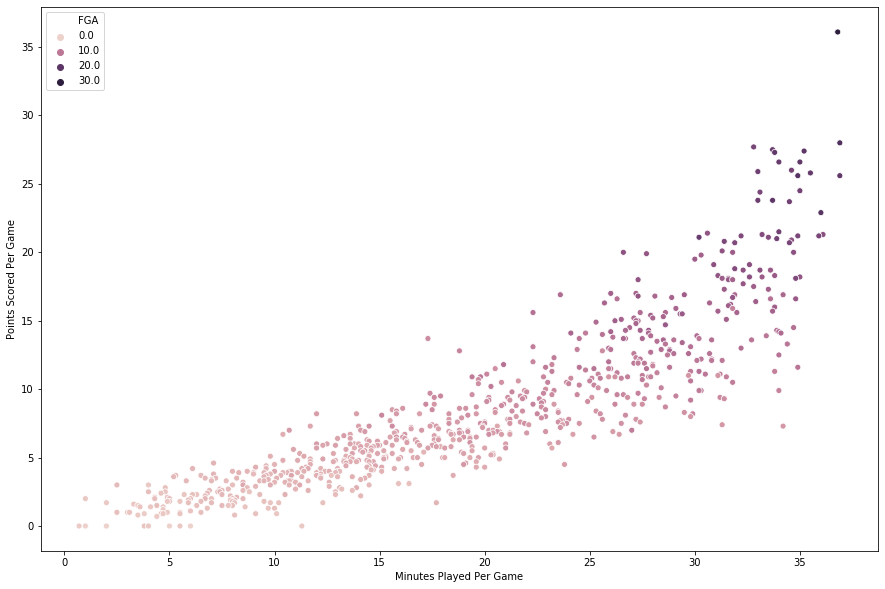

In [9]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the average points scored and minutes played for all players
ax = sns.scatterplot(x = 'MP', y = 'PTS', hue = 'FGA', data = nba_stats)

# Set up axes
ax.set_xlabel('Minutes Played Per Game')
ax.set_ylabel('Points Scored Per Game')

plt.show()

The above graph plots the minutes played per game and points per game scored for every player during the 2018-2019 season. Additionally, the hue of each circle represents how many field goals (2- or 3-point shots) per game that the player has attempted. The darker the circle, the more shots that player took during games. This graph demonstrates that the more minutes an NBA player plays in a game, the more points they will most likely score. However, the point behind this graph was primarily to show that there are clearly groups of players who tend to be playing and scoring more than other players. A portion of the players in the upper/middle right of the graph are the ones we will be looking at in the next graph.

<center>
<h1 style="font-size:20px">Points Scored v. Minutes Played for Top 15 Scorers</h1>

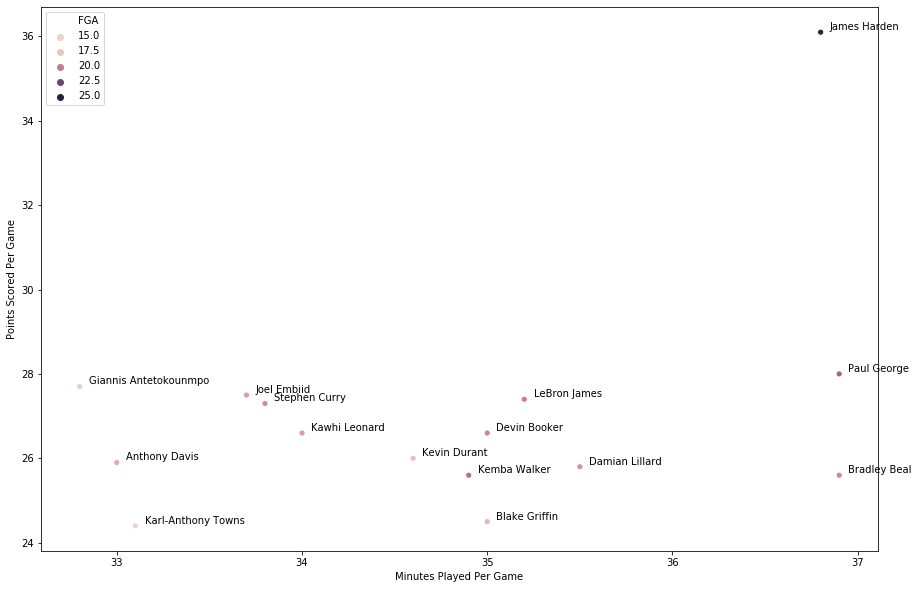

In [10]:
plt.figure(figsize = (15, 10))
# Get top 15 scorers
top_15 = nba_stats.head(15)
# Create a scatterplot of the average points scored and minutes played for top 15 scorers
ax = sns.scatterplot(x = 'MP', y = 'PTS', hue = 'FGA', data = top_15)

# Lable points with player's name associated with them
for line in range(0, top_15.shape[0]):
    plt.text(top_15.MP[line] + 0.05, top_15.PTS[line] + 0.05,
            top_15.Player[line], horizontalalignment = 'left',
            size = '10', color = 'black')

# Set up axes
ax.set_xlabel('Minutes Played Per Game')
ax.set_ylabel('Points Scored Per Game')
    
plt.show()

Just like the prior graph, this graph plots the minutes played per game and points per game scored by players during the 2018-2019 season. However, this graph focuses on only the top 15 players with the highest points per game instead of every player. The hue of each circle still represents the number of field goals that player attempted per game. It is important to note that the hue color differs from the previous graph due to this being only the top 15 scorers. It is also important to note that points and minutes played are not the only factor in selecting an MVP. Despite James Harden having the most points per game last year, the MVP award was given to Giannis Antetokounmpo.

<center>
<h1 style="font-size:20px">Field Goals Attempted v. Field Goal Percentage For All NBA Players</h1>

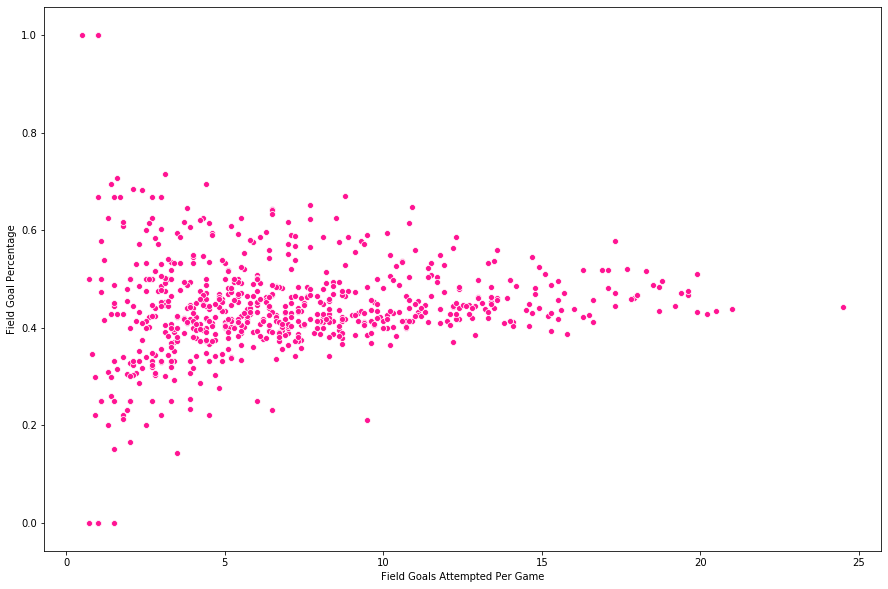

In [11]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the average field goals attempted vs field goal percentage for all scorers
ax = sns.scatterplot(x = 'FGA', y = 'FG%', data = nba_stats, color = 'deeppink')

# Set up axes
ax.set_xlabel('Field Goals Attempted Per Game')
ax.set_ylabel('Field Goal Percentage')

plt.show()

This graph is showing the field goals attempted per game and field goal percentages of all players. Overall, the graph shows no linear relationship between the two variables. The majority of players have a field goal percentage ranging from 35% to 55%. The majority of players also tend to attempt under 15 field goals on average. Similar to the previous plots we can see that there is a smaller concentration of players that attempt more than 15 shots per game. This shows that there is only a handful of players that are in a position to be taking 15 plus shots for their team. Naturally, we would expect these players to be superstars and MVP prospects.

<center>
<h1 style="font-size:20px">Field Goals Attempted v. Field Goal Percentage For Top 15 Scorers</h1>

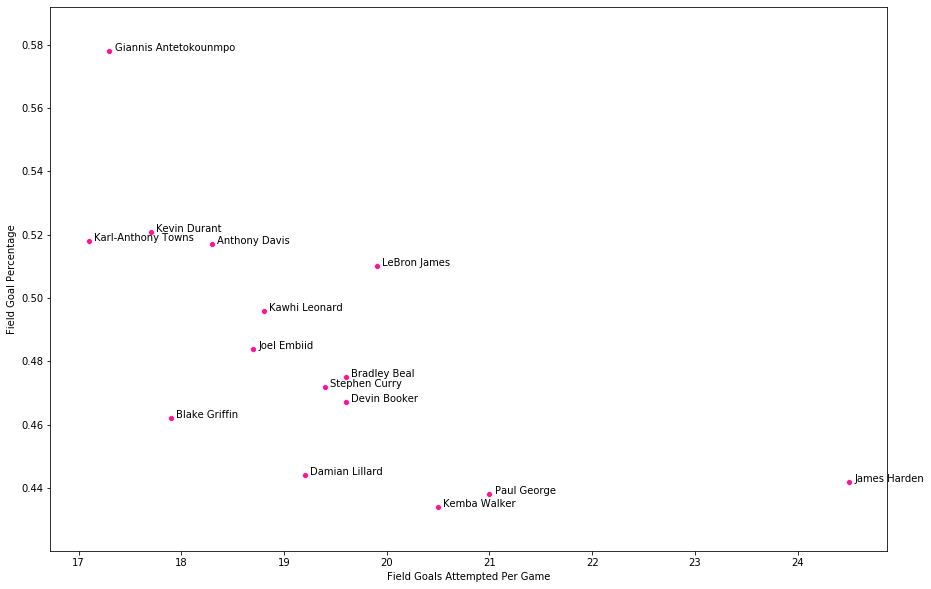

In [12]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the average field goals attempted vs field goal percentage for top 15 scorers
ax = sns.scatterplot(x = 'FGA', y = 'FG%', data = top_15, color = 'deeppink')

# Lable points with player's name associated with them
for line in range(0,top_15.shape[0]):
    plt.text(top_15['FGA'][line] + 0.05, top_15['FG%'][line],
            top_15['Player'][line], horizontalalignment = 'left',
            size = '10', color = 'black')
    
# Set up axes
ax.set_xlabel('Field Goals Attempted Per Game')
ax.set_ylabel('Field Goal Percentage')
    
plt.show()

This graph is showing the number of field goals attempted per game and field goal percentages for the top 15 scorers. In comparison to the prior graph, these players would be located towards the right side of the plot. These players have similar field goal percentages to the majority of NBA Players. Giannis Antetokounmpo, the previously discussed MVP winner, has the highest field goal percentage. James Harden has the most field goals attempted (and the most points scored as shown in a previous graph), but he also has one of the lowest field goal percentage out of all of these top scorers. This shows us that efficiency in scoring could potentially be more important to voters when deciding the MVP than overall points scored. Due to the increased pace of the league in recent years, more shots are being taken per game, and thus field goal efficiency is especially important for a superstar player to exhibit in order for teams to be successful.

<center>
<h1 style="font-size:20px">Total Rebounds Per Game v. Minutes Played Per Game For All NBA Players</h1>

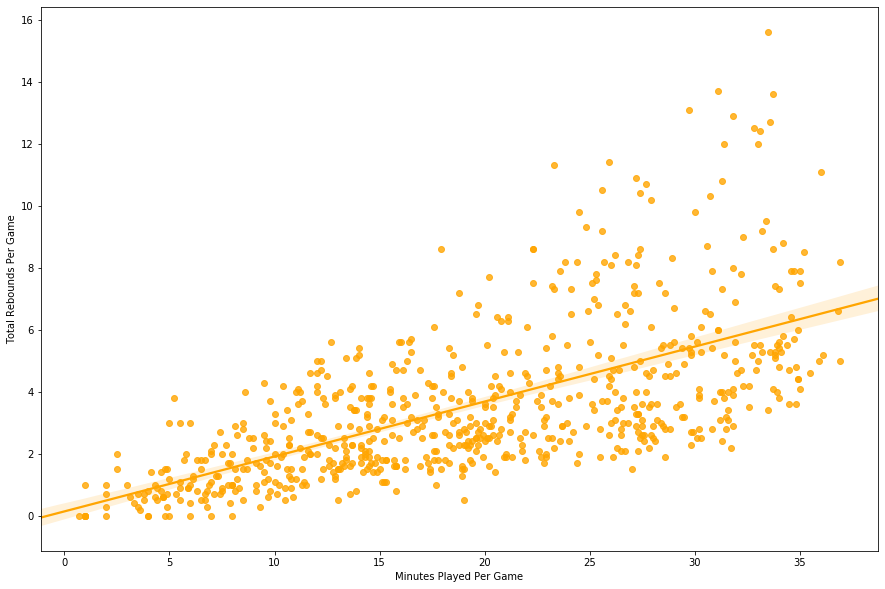

In [13]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the total rebounds per game vs minutes played per game for top all scorers
ax = sns.regplot(x = 'MP', y = 'TRB', data = nba_stats, color = 'orange')

# Set up axes
ax.set_xlabel('Minutes Played Per Game')
ax.set_ylabel('Total Rebounds Per Game')

plt.show()

This graph is showing the total rebounds per game and minutes played per game for all players. The graph depicts how there tends to be a linear relationship showing that as minutes played per game increases so does total rebounds per game (Which is shown by the regression line). One can see that similar to other counting statistics, there tends to be a group of players that are rebounding at a much higher rate than an average NBA player. 

<center>
<h1 style="font-size:20px">Total Rebounds Per Game v. Minutes Played Per Game For Top 15 Scorers</h1>

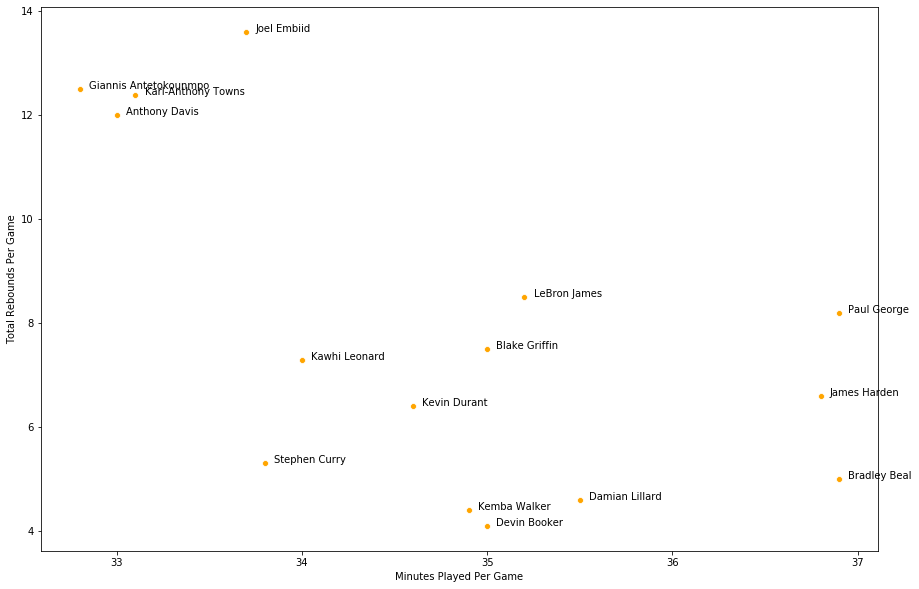

In [14]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the total rebounds per game vs minutes per game played for top 15 scorers
ax = sns.scatterplot(x = 'MP', y = 'TRB', data = top_15, color = 'orange')

# Lable points with player's name associated with them
for line in range(0,top_15.shape[0]):
    plt.text(top_15['MP'][line] + 0.05, top_15['TRB'][line],
            top_15['Player'][line], horizontalalignment = 'left',
            size = '10', color = 'black')
    
# Set up axes
ax.set_xlabel('Minutes Played Per Game')
ax.set_ylabel('Total Rebounds Per Game')

plt.show()

This graph shows the total rebounds per game and minutes played per game for the top 15 scorers. Unlike the previous graphs the top 15 scorers are not necessarily top rebounders in the league. It seems that these two statistics (scoring and rebounding) are not strongly correlated. However, rebounding can still be important when trying the determine the MVP, as Giannis Antetokounmpo is averaging just over 12 rebounds per game which is well above the league average.

<center>
<h1 style="font-size:20px">Assists v. Minutes Played For All NBA Players</h1>

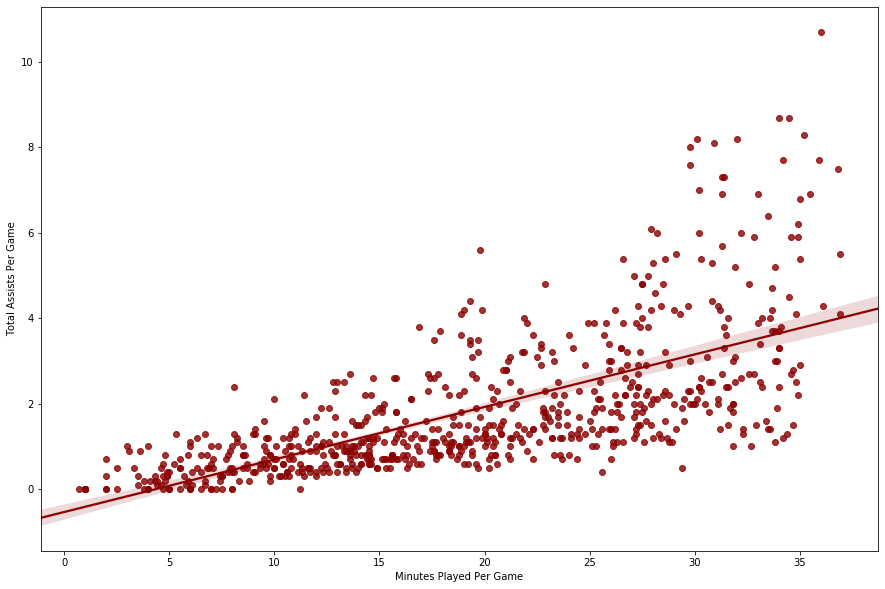

In [15]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the assists per game vs minutes played per game for all players
ax = sns.regplot(x = 'MP', y = 'AST', data = nba_stats, color = 'darkred')

# Set up axes
ax.set_xlabel('Minutes Played Per Game')
ax.set_ylabel('Total Assists Per Game')

plt.show()

One can see through this graph that minutes played per game has a linear relationship with total assists per game in this dataset. The spread of this graph seems to be smaller than the spread of the rebounding graph, meaning it is harder for the average player to accumulate assists than rebounds. 

<center>
<h1 style="font-size:20px">Assists v. Minutes Played For Top 15 Scorers</h1>

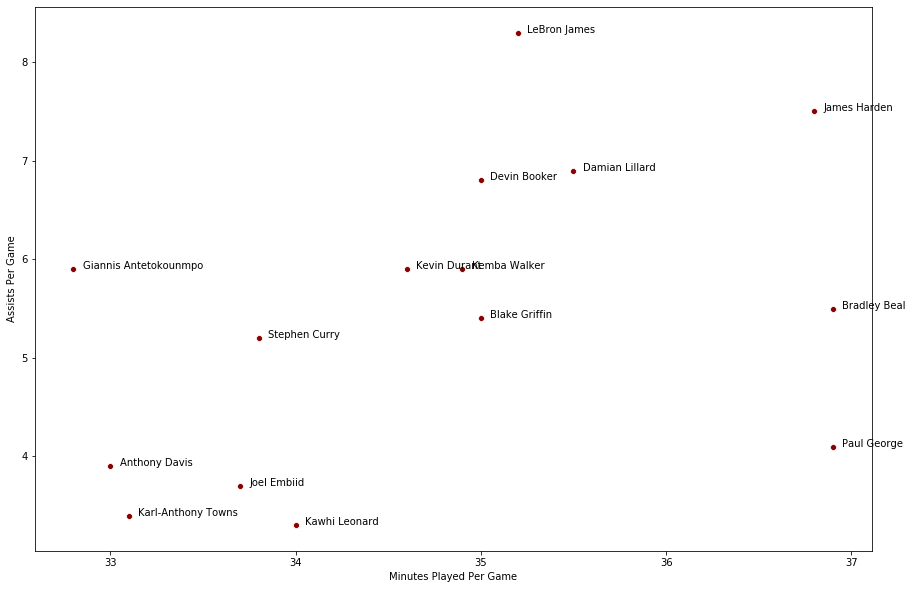

In [16]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the average total assits vs average minutes played for top 15 players
ax = sns.scatterplot(x = 'MP', y = 'AST', data = top_15, color = 'darkred')

# Lable points with player's name associated with them
for line in range(0, top_15.shape[0]):
    plt.text(top_15['MP'][line] + 0.05, top_15['AST'][line],
            top_15['Player'][line], horizontalalignment = 'left',
            size = '10', color = 'black')
    
# Set up axes
ax.set_xlabel('Minutes Played Per Game')
ax.set_ylabel('Assists Per Game')

plt.show()

This graph highlights how the top 15 scorers are above the league average in assists for their minutes played. MVP awards are decided based on more than just scoring, players who can help their team by producing points and putting their teammates in positions to score are going to be considered above other players in MVP voting. This can be seen in perennial MVP candidates such as James Harden and LeBron James who are near the top in assists in the graph above.

<center>
<h1 style="font-size:20px">Steals v. Minutes Played For All NBA Players</h1>

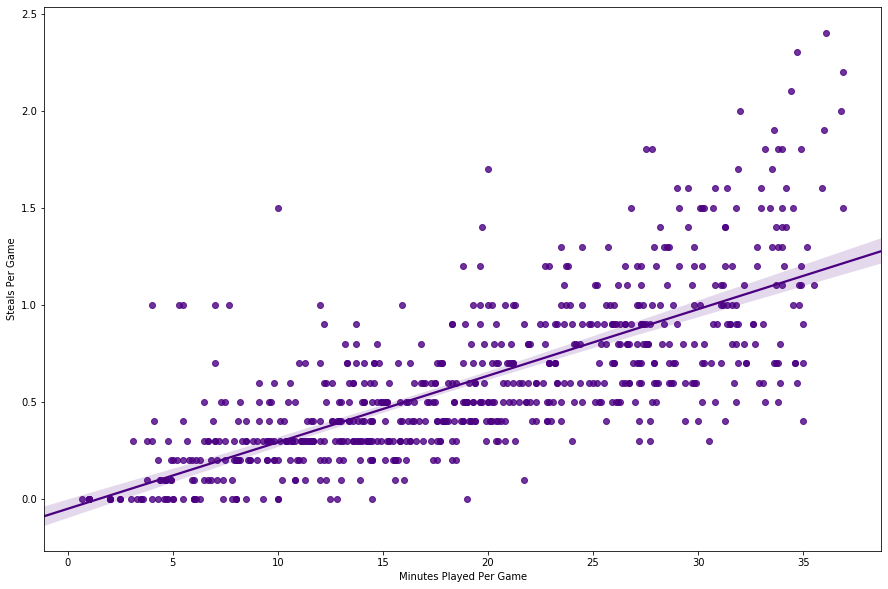

In [17]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the steals v. minutes played for all players
ax = sns.regplot(x = 'MP', y = 'STL', data = nba_stats, color = 'indigo')

# Set up axes
ax.set_xlabel('Minutes Played Per Game')
ax.set_ylabel('Steals Per Game')

plt.show()

This graph shows a linear relationship between minutes played and steals per game. Due to the small range of values for steals many of the data points lie on the same horizontal line, as nobody in the league averages more than 2.5 steals per game. 

<center>
<h1 style="font-size:20px">Total Steals v. Minutes Played For Top 15 Scorers</h1>

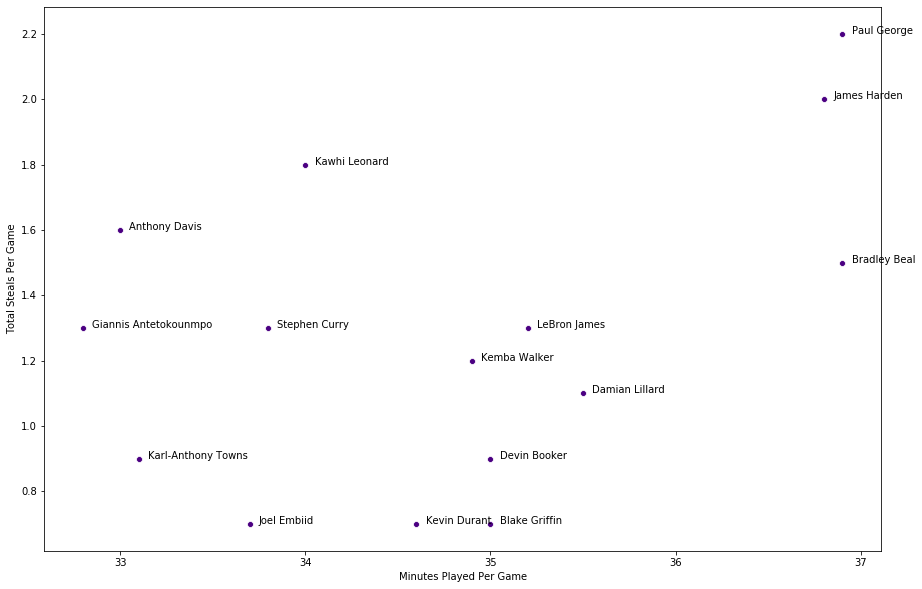

In [18]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the average total steals vs average minutes played for top 15 players
ax = sns.scatterplot(x = 'MP', y = 'STL', data = top_15, color = 'indigo')

# Lable points with player's name associated with them
for line in range(0,top_15.shape[0]):
    plt.text(top_15['MP'][line] + 0.05, top_15['STL'][line],
            top_15['Player'][line], horizontalalignment = 'left',
            size = '10', color = 'black')
    
# Set up axes
ax.set_xlabel('Minutes Played Per Game')
ax.set_ylabel('Total Steals Per Game')

plt.show()

We can see in this graph that the top 15 scorers have a similar range of values as the entire NBA. This is most likely because steals are a defensive statistic and, in all likelihood, will not have an effect on who the top 15 scorers in the league are. However, some MVP candidates such as James Harden are near the top of the league in steals, thus making it a statistic that could be taken into consideration when differentiating between leading MVP candidates.

<center>
<h1 style="font-size:20px">Free Throw Percentage v. Free Throw Attempts For All NBA Players</h1>

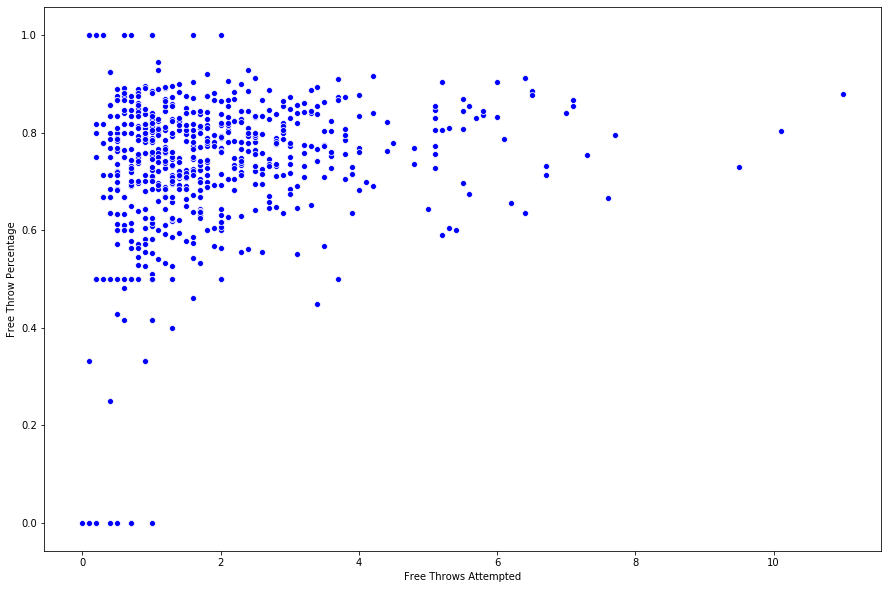

In [19]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the free throw percentage vs free throw attempts for all players
ax = sns.scatterplot(x = 'FTA', y = 'FT%', data = nba_stats, color = 'blue')

# Set up axes
ax.set_xlabel('Free Throws Attempted')
ax.set_ylabel('Free Throw Percentage')

plt.show()

We decided to look at free throw percentages as they are a crucial part of the game and can be the deciding factor in games. Also, if you are interested in the importance of free throws <a href="https://medium.com/push-the-pace/fact-or-fiction-is-college-free-throw-percentage-better-than-college-three-point-percentage-at-8c77a7e3f09a">here</a> is an interesting article on why free throw percentage is a good indicator of shooting success for draft prospects. In the graph above the points behave similarly to steals due to the smaller range of values present in the data.

<center>
<h1 style="font-size:20px">Free Throw Percentage v. Free Throw Attempts For Top 15 Scorers</h1>

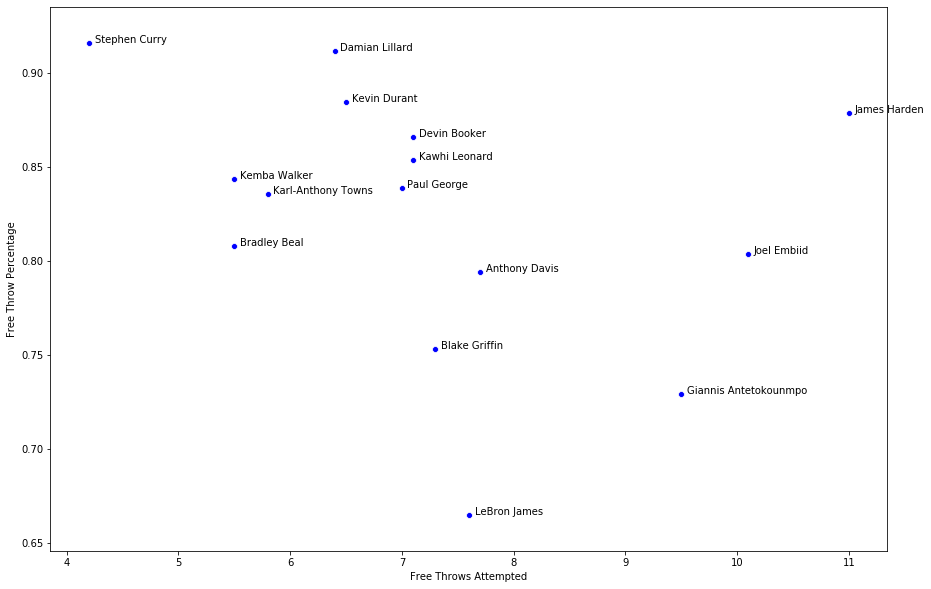

In [20]:
plt.figure(figsize = (15, 10))
# Create a scatterplot of the free throw percentage vs free throw attempts for top 15 players
ax = sns.scatterplot(x = 'FTA', y = 'FT%', data = top_15, color = 'blue')

# Lable points with player's name associated with them
for line in range(0,top_15.shape[0]):
    plt.text(top_15['FTA'][line] + 0.05, top_15['FT%'][line],
            top_15['Player'][line], horizontalalignment = 'left',
            size = '10', color = 'black')

# Set up axes
ax.set_xlabel('Free Throws Attempted')
ax.set_ylabel('Free Throw Percentage')

plt.show()

Most of the top 15 scorers have above an 80% free throw percentage. Giannis Antetokounmpo is lower than almost all of the players on this graph, but as previously mentioned he has outperformed most of these players in our previous visualizations.   

<center>
<h1 style="font-size:24px">Advanced Statistics Visualizations</h1>
<h1 style="font-size:20px">Player Efficiency Rating v. Player For Top 15 Scorers</h1>

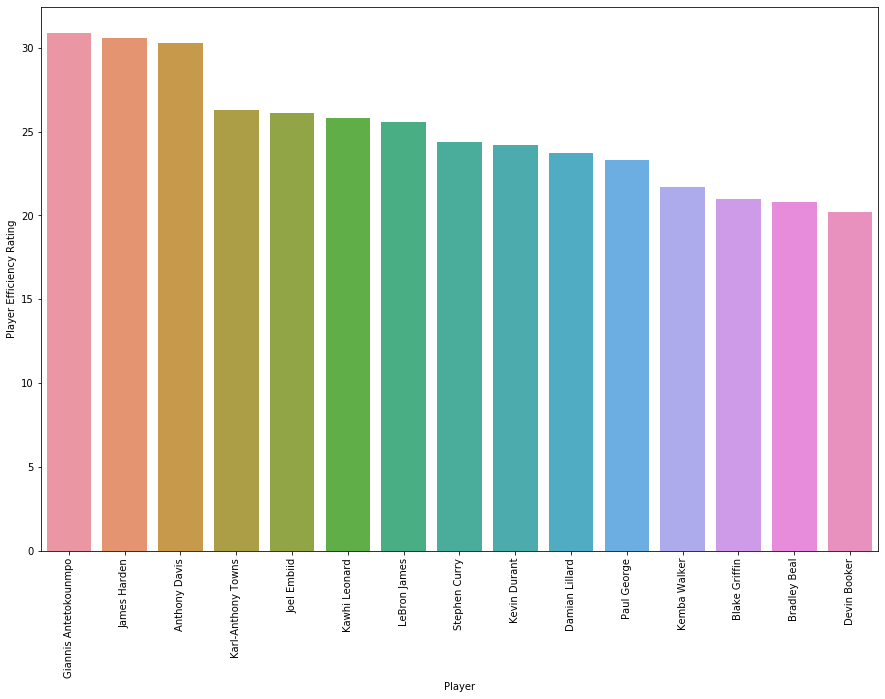

In [21]:
plt.figure(figsize = (15, 10))
# Get top 15 players
top_15 = nba_stats.head(15)
# Order top 15 players by player efficiency rating in decending order
top_15 = top_15.sort_values(by = ['PER'], ascending = False)
# Create a barplot of the player efficiency rating for the top 15 players
ax = sns.barplot(x = 'Player', y = 'PER', data = top_15)

# Set up axes
ax.set_xlabel('Player')
ax.set_ylabel('Player Efficiency Rating')

# Make x axis lables vertical
plt.xticks(rotation = 'vertical')

plt.show()

The Player Efficiency Rating (PER) is a measure of per-minute production standardized such that the league average is 15. This definition and the definitions of the following advanced statistics were taken from Basketball Reference.

<center>
<h1 style="font-size:20px">Box Plus/Minus v. Player For Top 15 Scorers</h1>

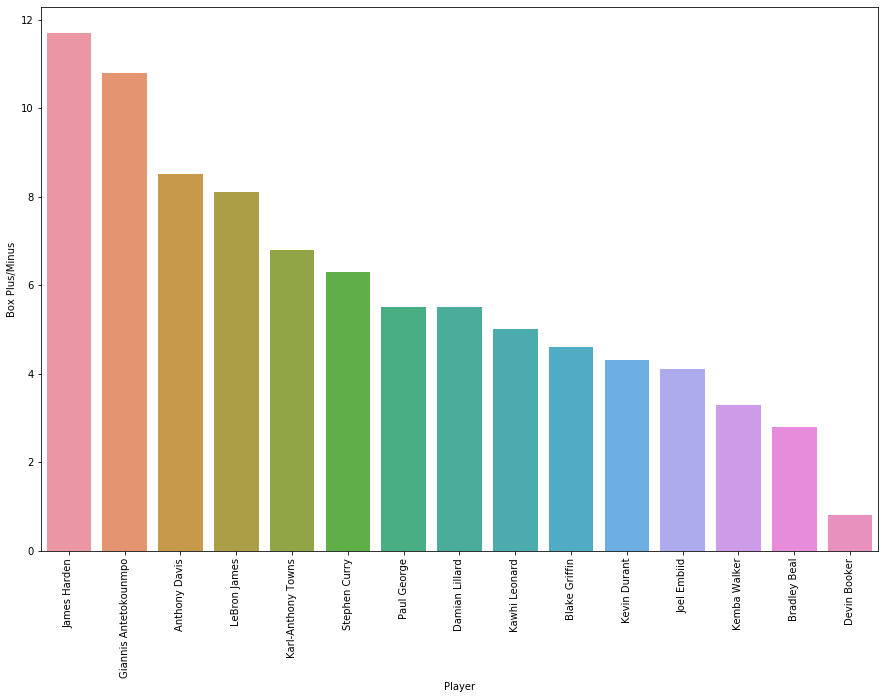

In [22]:
plt.figure(figsize = (15, 10))
# Get top 15 players
top_15 = nba_stats.head(15)
# Order top 15 players by box plus/minus in decending order
top_15 = top_15.sort_values(by = ['BPM'], ascending = False)
# Create a barplot of the box plus/minus for the top 15 players
ax = sns.barplot(x = 'Player', y = 'BPM', data = top_15)

# Set up axes
ax.set_xlabel('Player')
ax.set_ylabel('Box Plus/Minus')

# Make x axis lables vertical
plt.xticks(rotation = 'vertical')

plt.show()

The Box Plus/Minus (BPM) is a box score estimate of the points per 100 possessions a player contributed above a league-average player, translated to an average team. 

<center>
<h1 style="font-size:20px">Value Over Replacement Player v. Player For Top 15 Scorers</h1>

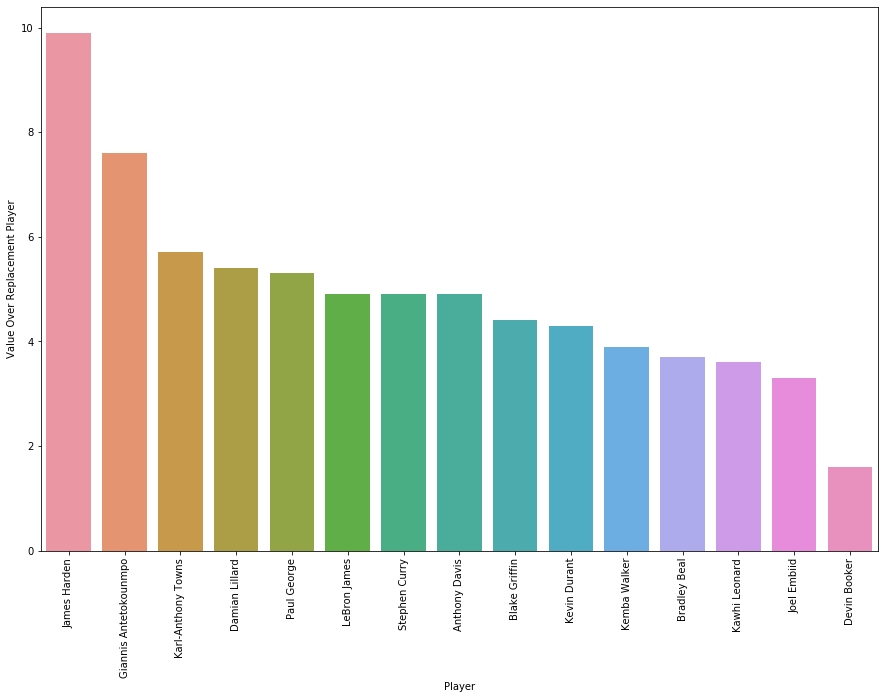

In [23]:
plt.figure(figsize = (15, 10))
# Get top 15 players
top_15 = nba_stats.head(15)
# Order top 15 players by value over replacement player in decending order
top_15 = top_15.sort_values(by = ['VORP'], ascending = False)
# Create a barplot of the value over replacement player for the top 15 players
ax = sns.barplot(x = 'Player', y = 'VORP', data = top_15)

# Set up axes
ax.set_xlabel('Player')
ax.set_ylabel('Value Over Replacement Player')

# Make x axis lables vertical
plt.xticks(rotation = 'vertical')

plt.show()

The Value Over Replacement Player (VORP) is a box score estimate of the points per 100 TEAM possessions that a player contributed above a replacement-level (-2.0) player, translated to an average team and prorated to an 82-game season.

<center>
<h1 style="font-size:20px"> Win Shares v. Player For Top 15 Scorers</h1>

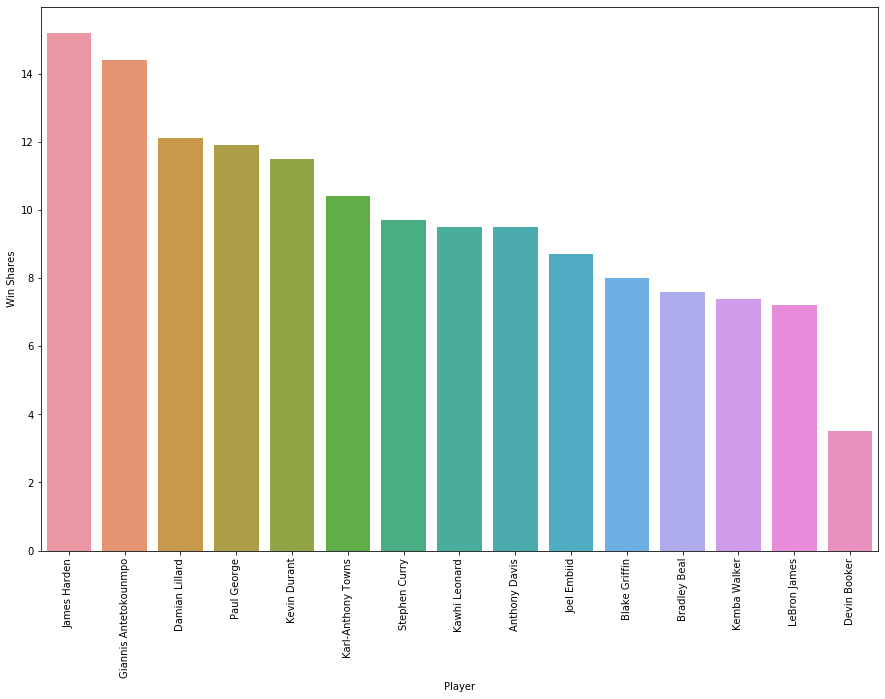

In [24]:
plt.figure(figsize = (15, 10))
# Get top 15 players
top_15 = nba_stats.head(15)
# Order top 15 players by win shares in decending order
top_15 = top_15.sort_values(by = ['WS'], ascending = False)
# Create a barplot of the win shares for the top 15 players
ax = sns.barplot(x = 'Player', y = 'WS', data = top_15)

# Set up axes
ax.set_xlabel('Player')
ax.set_ylabel('Win Shares')

# Make x axis lables vertical
plt.xticks(rotation = 'vertical')

plt.show()

A Win Share (WS) is an estimate of the number of wins contributed by a player.
<br>
<br>
<center>
<h1 style="font-size:20px">Advanced Statistics Visualizations Analysis</h1>
All of these graphs above show that James Harden and Giannis Antetokounmpo, the top two MVP contenders of the 2018-2019 season, were leading in advanced statistics categories. Thus, this shows that these advanced statistics weigh heavily when it comes to selecting an MVP.

<center>
<h1 style="font-size:20px"> Win Percentage v. Player For Top 15 Scorers</h1>

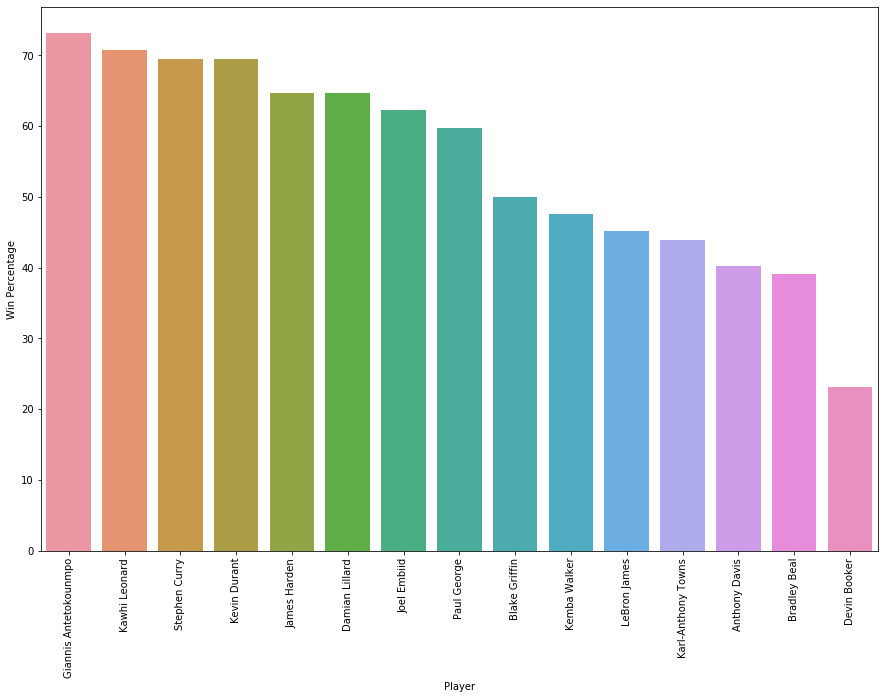

In [25]:
plt.figure(figsize = (15, 10))
# Get top 15 players
top_15 = nba_stats.head(15)
# Order top 15 players by win shares in decending order
top_15 = top_15.sort_values(by = ['W%'], ascending = False)
# Create a barplot of the win shares for the top 15 players
ax = sns.barplot(x = 'Player', y = 'W%', data = top_15)

# Set up axes
ax.set_xlabel('Player')
ax.set_ylabel('Win Percentage')

# Make x axis lables vertical
plt.xticks(rotation = 'vertical')

plt.show()

<center>
<h1 style="font-size:28px">Predicting the Most Valuable Player Award</h1>
<br>
<h1 style="font-size:24px">Getting the Current Season Data</h1>
<br>

We will be predicting the most valuable player for the current season (2019-2020). In order to do this we will need to get the player data for the current statistics this season. The dataset can be found <a href="https://www.basketball-reference.com/leagues/NBA_2020_per_game.html">here</a>. Similar to before we merged the counting and advanced statistics from a dataset which can be found <a href="https://www.basketball-reference.com/leagues/NBA_2020_advanced.html">here</a>. This data will be used on our model to predict the voting shares for each prospective MVP, which will be explained more later.

In [26]:
# Import the data
curr_stats = pd.read_csv("19_20_nba_stats.csv")
curr_stats_advanced = pd.read_csv("19_20_stats_advanced.csv")
curr_stats = curr_stats.drop(columns = ["Rk"])
curr_stats_advanced = curr_stats_advanced.drop(columns = ["Rk"])

clean_name_column(curr_stats)
clean_name_column(curr_stats_advanced)

# Merge the per game and advanced player statistics together. Drops any duplicate columns.
curr_stats = curr_stats.merge(right = curr_stats_advanced, how = 'outer', on = "Player", suffixes = ('', '_repeat'))

# Drop any repeated columns (they end in _repeat)
curr_stats = curr_stats[curr_stats.columns.drop(list(curr_stats.filter(regex='_repeat')))]

# Sort the dataframe by points
curr_stats = curr_stats.sort_values(by="PTS", ascending = False)

curr_stats = curr_stats.reset_index()
curr_stats = curr_stats.drop(columns = ["index"])

curr_stats.head(20)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,James Harden,SG,30.0,HOU,23.0,23.0,37.7,10.3,24.0,0.431,4.7,13.8,0.338,5.7,10.2,0.557,0.528,12.6,14.3,0.879,1.0,5.1,6.0,7.5,2.0,0.6,5.1,3.3,38.0,31.1,0.633,0.572,0.572,2.5,13.5,8.1,35.4,2.4,1.4,14.4,38.2,4.5,1.0,5.5,0.291,10.6,-0.5,10.1,2.8
1,Giannis Antetokounmpo,PF,25.0,MIL,24.0,24.0,31.6,11.5,20.3,0.564,1.6,5.0,0.319,9.9,15.4,0.642,0.602,6.4,10.8,0.588,2.7,10.5,13.2,5.5,1.3,1.3,3.8,3.2,30.9,33.7,0.615,0.244,0.533,9.0,31.2,20.7,31.6,1.9,3.6,13.1,37.6,2.9,2.0,4.9,0.309,7.5,5.1,12.6,2.8
2,Luka Dončić,PG,20.0,DAL,23.0,23.0,33.4,9.7,20.3,0.476,3.0,9.5,0.320,6.6,10.7,0.615,0.552,7.6,9.3,0.814,1.3,8.5,9.8,9.2,1.3,0.1,4.6,2.4,30.0,32.1,0.619,0.473,0.463,4.3,25.9,15.5,48.0,1.8,0.3,15.5,36.9,3.9,1.2,5.0,0.301,11.2,2.4,13.7,3.2
3,Trae Young,PG,21.0,ATL,22.0,22.0,34.6,9.5,20.5,0.462,3.5,8.9,0.388,6.0,11.5,0.520,0.547,6.4,7.5,0.860,0.5,3.6,4.1,8.4,1.3,0.0,4.9,1.3,28.8,23.4,0.597,0.441,0.364,1.5,11.5,6.5,43.8,1.7,0.1,17.5,34.0,1.9,0.0,2.0,0.114,6.9,-3.3,3.5,1.2
4,Bradley Beal,SG,26.0,WAS,22.0,22.0,37.0,9.6,21.3,0.453,2.6,7.7,0.343,7.0,13.6,0.515,0.515,6.0,7.2,0.836,1.0,3.5,4.5,7.0,1.0,0.2,3.5,2.7,28.0,20.2,0.564,0.361,0.337,2.9,10.7,6.7,28.8,1.1,0.6,12.7,31.0,1.7,-0.2,1.5,0.087,3.8,-3.3,0.5,0.5
5,Anthony Davis,PF,26.0,LAL,23.0,23.0,34.4,9.7,19.0,0.507,1.1,3.3,0.333,8.6,15.8,0.543,0.535,7.3,8.3,0.870,2.4,6.6,9.0,3.3,1.5,2.7,2.3,2.3,27.7,29.8,0.599,0.172,0.428,8.3,20.8,14.7,15.8,2.1,6.8,9.0,30.8,3.0,1.9,5.0,0.288,3.6,4.0,7.6,2.0
6,Damian Lillard,PG,29.0,POR,22.0,22.0,36.9,8.3,18.7,0.443,3.1,9.0,0.350,5.1,9.7,0.528,0.527,7.0,7.7,0.911,0.5,4.1,4.6,7.4,1.0,0.5,2.9,2.0,26.7,24.5,0.607,0.493,0.398,1.4,10.8,6.1,32.3,1.3,1.0,11.6,28.2,3.3,0.4,3.7,0.201,7.4,-2.3,5.1,1.6
7,Karl-Anthony Towns,C,24.0,MIN,21.0,21.0,33.7,9.0,17.4,0.516,3.6,8.4,0.424,5.4,9.0,0.603,0.619,4.6,5.7,0.800,2.6,9.1,11.7,4.5,1.0,1.4,3.0,3.4,26.1,28.1,0.651,0.488,0.339,8.3,27.8,18.0,23.0,1.4,3.1,13.3,27.9,2.9,0.8,3.6,0.235,7.5,1.3,8.8,2.0
8,LeBron James,PG,35.0,LAL,24.0,24.0,34.4,10.0,19.9,0.501,2.2,6.0,0.364,7.8,13.9,0.560,0.556,3.8,5.4,0.705,1.0,5.9,6.8,10.8,1.3,0.5,3.7,1.8,25.9,27.3,0.577,0.297,0.267,3.3,18.7,11.2,51.6,1.8,1.3,14.5,32.3,2.9,1.5,4.4,0.244,7.2,2.1,9.3,2.5
9,Devin Booker,SG,23.0,PHO,23.0,23.0,35.7,9.0,17.5,0.514,2.3,5.7,0.415,6.7,11.9,0.560,0.581,5.1,5.7,0.908,0.6,3.3,3.9,6.3,0.6,0.3,3.9,3.1,25.5,19.9,0.627,0.317,0.319,1.8,10.4,6.0,29.5,0.8,0.8,16.0,27.9,2.0,0.4,2.4,0.135,3.6,-1.9,1.7,0.8


<center>
<h1 style="font-size:24px">Getting the Historical Data</h1>

In order to predict who will win the MVP award we will need to predict the voting shares for each of the prospective winners. We will be using historical data from the 1997-1998 MVP voting to train our model on. We decided to take this season as our training data instead of the 2018-2019 season because we did not want any players to overlap between the two voting periods. The voting data for the 1997-1998 season can be found <a href="https://www.basketball-reference.com/awards/awards_1998.html">here</a>. After getting this data we merged it with an additional dataset of the advanced stats for the players of the 1997-1998 season which can be found <a href="https://www.basketball-reference.com/leagues/NBA_1998_advanced.html">here</a>. We merged in this dataset because we will be using some of these advanced stats in our model.

In [27]:
# Importing the historical data 
past_mvp_voting = pd.read_csv('historic_mvp_voting.csv')
historical_data_advanced = pd.read_csv('97_98_advanced_stats.csv')
clean_name_column(historical_data_advanced)
clean_name_column(past_mvp_voting)

for i, row in historical_data_advanced.iterrows():
    if row.Player.endswith("*"):
        historical_data_advanced.at[i, 'Player'] = row.Player[:-1]

# Merge the per game and advanced player statistics together. Drops any duplicate columns.
past_mvp_voting = past_mvp_voting.merge(right = historical_data_advanced, how = "outer" ,on = "Player", suffixes = ('', '_repeat'))

# Drop any repeated columns (they end in _repeat)
past_mvp_voting = past_mvp_voting[past_mvp_voting.columns.drop(list(past_mvp_voting.filter(regex='_repeat')))]

past_mvp_voting = past_mvp_voting.dropna()

past_mvp_voting

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Rk,Pos,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,OBPM,DBPM,BPM,VORP
0,1,Michael Jordan,34.0,CHI,92.0,1084.0,1160.0,0.934,82.0,38.8,28.7,5.8,3.5,1.7,0.5,0.465,0.238,0.784,15.8,0.238,241,SG,25.2,0.533,0.067,0.381,4.7,12.5,8.5,18.0,2.4,1.0,7.7,33.7,10.4,5.4,4.6,0.0,4.6,5.3
1,2,Karl Malone,34.0,UTA,20.0,842.0,1160.0,0.726,81.0,37.4,27.0,10.3,3.9,1.2,0.9,0.530,0.333,0.761,16.4,0.259,276,PF,27.9,0.597,0.004,0.560,8.3,24.8,17.1,20.9,1.7,1.7,11.9,31.8,12.1,4.3,5.7,1.4,7.0,6.9
2,3,Gary Payton,29.0,SEA,3.0,431.0,1160.0,0.372,82.0,38.4,19.2,4.6,8.3,2.3,0.2,0.453,0.338,0.744,12.5,0.190,345,PG,21.6,0.544,0.311,0.293,3.0,11.2,7.1,36.7,3.1,0.4,13.7,24.6,8.5,4.0,4.9,0.1,5.0,5.6
4,5,Tim Duncan,21.0,SAS,0.0,148.0,1160.0,0.128,82.0,39.1,21.1,11.9,2.7,0.7,2.5,0.549,0.000,0.662,12.8,0.192,138,PF,22.6,0.577,0.008,0.375,10.5,23.8,17.6,13.7,0.9,4.5,15.7,26.0,5.6,7.2,1.8,3.7,5.5,6.0
5,6,Tim Hardaway,31.0,MIA,0.0,71.0,1160.0,0.061,81.0,37.4,18.9,3.7,8.3,1.7,0.2,0.431,0.351,0.781,11.7,0.185,196,PG,20.6,0.530,0.341,0.254,1.9,9.4,5.8,41.3,2.4,0.4,13.5,25.6,7.9,3.8,5.1,-0.5,4.6,5.1
6,7,David Robinson,32.0,SAS,0.0,36.0,1160.0,0.031,73.0,33.7,21.6,10.6,2.7,0.9,2.6,0.511,0.250,0.735,13.8,0.269,387,C,27.8,0.581,0.004,0.620,12.0,23.7,18.2,15.9,1.4,5.5,13.0,29.7,7.8,6.0,3.7,4.1,7.8,6.1
7,8,Vin Baker,26.0,SEA,0.0,24.0,1160.0,0.021,82.0,35.9,19.2,8.0,1.9,1.1,1.0,0.542,0.143,0.591,10.4,0.169,27,C,20.4,0.564,0.006,0.452,11.8,14.8,13.3,9.3,1.7,2.2,11.1,24.7,6.9,3.5,1.9,0.2,2.0,3.0
8,9,Grant Hill,25.0,DET,0.0,23.0,1160.0,0.020,81.0,40.7,21.1,7.7,6.8,1.8,0.7,0.452,0.143,0.740,10.2,0.149,208,SF,21.2,0.520,0.015,0.475,3.3,19.3,11.3,31.5,2.4,1.2,14.8,27.3,5.2,5.1,2.4,2.4,4.8,5.6
9,10,Scottie Pippen,32.0,CHI,0.0,14.0,1160.0,0.012,44.0,37.5,19.1,5.2,5.8,1.8,1.0,0.447,0.318,0.777,6.6,0.193,357,SF,20.4,0.533,0.273,0.274,3.7,12.1,7.9,26.5,2.6,1.9,12.1,24.4,3.7,3.0,4.0,1.8,5.8,3.2
10,11,Glen Rice,30.0,CHH,0.0,7.0,1160.0,0.006,82.0,40.2,22.3,4.3,2.2,0.9,0.3,0.457,0.433,0.849,9.3,0.136,377,SF,17.4,0.568,0.216,0.364,3.3,9.6,6.5,9.9,1.3,0.5,10.2,25.1,7.4,2.0,2.6,-1.9,0.7,2.3


<center>
<h1 style="font-size:24px">Picking Prospective MVPs</h1>

We want to pick prospective MVPs to test our model on. Similar to before, we will be looking at the top 15 scorers in the league as there is seldom an MVP not in the top 15 scorers.

In [28]:
# Get the top 15 scorers
prospective_mvps = curr_stats.head(15)
# Used to make the graphs of the results later on 
results = prospective_mvps.filter(["Player"])

prospective_mvps

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,James Harden,SG,30.0,HOU,23.0,23.0,37.7,10.3,24.0,0.431,4.7,13.8,0.338,5.7,10.2,0.557,0.528,12.6,14.3,0.879,1.0,5.1,6.0,7.5,2.0,0.6,5.1,3.3,38.0,31.1,0.633,0.572,0.572,2.5,13.5,8.1,35.4,2.4,1.4,14.4,38.2,4.5,1.0,5.5,0.291,10.6,-0.5,10.1,2.8
1,Giannis Antetokounmpo,PF,25.0,MIL,24.0,24.0,31.6,11.5,20.3,0.564,1.6,5.0,0.319,9.9,15.4,0.642,0.602,6.4,10.8,0.588,2.7,10.5,13.2,5.5,1.3,1.3,3.8,3.2,30.9,33.7,0.615,0.244,0.533,9.0,31.2,20.7,31.6,1.9,3.6,13.1,37.6,2.9,2.0,4.9,0.309,7.5,5.1,12.6,2.8
2,Luka Dončić,PG,20.0,DAL,23.0,23.0,33.4,9.7,20.3,0.476,3.0,9.5,0.320,6.6,10.7,0.615,0.552,7.6,9.3,0.814,1.3,8.5,9.8,9.2,1.3,0.1,4.6,2.4,30.0,32.1,0.619,0.473,0.463,4.3,25.9,15.5,48.0,1.8,0.3,15.5,36.9,3.9,1.2,5.0,0.301,11.2,2.4,13.7,3.2
3,Trae Young,PG,21.0,ATL,22.0,22.0,34.6,9.5,20.5,0.462,3.5,8.9,0.388,6.0,11.5,0.520,0.547,6.4,7.5,0.860,0.5,3.6,4.1,8.4,1.3,0.0,4.9,1.3,28.8,23.4,0.597,0.441,0.364,1.5,11.5,6.5,43.8,1.7,0.1,17.5,34.0,1.9,0.0,2.0,0.114,6.9,-3.3,3.5,1.2
4,Bradley Beal,SG,26.0,WAS,22.0,22.0,37.0,9.6,21.3,0.453,2.6,7.7,0.343,7.0,13.6,0.515,0.515,6.0,7.2,0.836,1.0,3.5,4.5,7.0,1.0,0.2,3.5,2.7,28.0,20.2,0.564,0.361,0.337,2.9,10.7,6.7,28.8,1.1,0.6,12.7,31.0,1.7,-0.2,1.5,0.087,3.8,-3.3,0.5,0.5
5,Anthony Davis,PF,26.0,LAL,23.0,23.0,34.4,9.7,19.0,0.507,1.1,3.3,0.333,8.6,15.8,0.543,0.535,7.3,8.3,0.870,2.4,6.6,9.0,3.3,1.5,2.7,2.3,2.3,27.7,29.8,0.599,0.172,0.428,8.3,20.8,14.7,15.8,2.1,6.8,9.0,30.8,3.0,1.9,5.0,0.288,3.6,4.0,7.6,2.0
6,Damian Lillard,PG,29.0,POR,22.0,22.0,36.9,8.3,18.7,0.443,3.1,9.0,0.350,5.1,9.7,0.528,0.527,7.0,7.7,0.911,0.5,4.1,4.6,7.4,1.0,0.5,2.9,2.0,26.7,24.5,0.607,0.493,0.398,1.4,10.8,6.1,32.3,1.3,1.0,11.6,28.2,3.3,0.4,3.7,0.201,7.4,-2.3,5.1,1.6
7,Karl-Anthony Towns,C,24.0,MIN,21.0,21.0,33.7,9.0,17.4,0.516,3.6,8.4,0.424,5.4,9.0,0.603,0.619,4.6,5.7,0.800,2.6,9.1,11.7,4.5,1.0,1.4,3.0,3.4,26.1,28.1,0.651,0.488,0.339,8.3,27.8,18.0,23.0,1.4,3.1,13.3,27.9,2.9,0.8,3.6,0.235,7.5,1.3,8.8,2.0
8,LeBron James,PG,35.0,LAL,24.0,24.0,34.4,10.0,19.9,0.501,2.2,6.0,0.364,7.8,13.9,0.560,0.556,3.8,5.4,0.705,1.0,5.9,6.8,10.8,1.3,0.5,3.7,1.8,25.9,27.3,0.577,0.297,0.267,3.3,18.7,11.2,51.6,1.8,1.3,14.5,32.3,2.9,1.5,4.4,0.244,7.2,2.1,9.3,2.5
9,Devin Booker,SG,23.0,PHO,23.0,23.0,35.7,9.0,17.5,0.514,2.3,5.7,0.415,6.7,11.9,0.560,0.581,5.1,5.7,0.908,0.6,3.3,3.9,6.3,0.6,0.3,3.9,3.1,25.5,19.9,0.627,0.317,0.319,1.8,10.4,6.0,29.5,0.8,0.8,16.0,27.9,2.0,0.4,2.4,0.135,3.6,-1.9,1.7,0.8


<center>
<h1 style="font-size:24px">Picking Stats to Use in Model</h1>

We want to look at the correlation between statistics to ensure that we are picking statistics that are not heavily correlated in our model. We will use a Pearson correlation heatmap to see the correlation coefficient between these statistics.

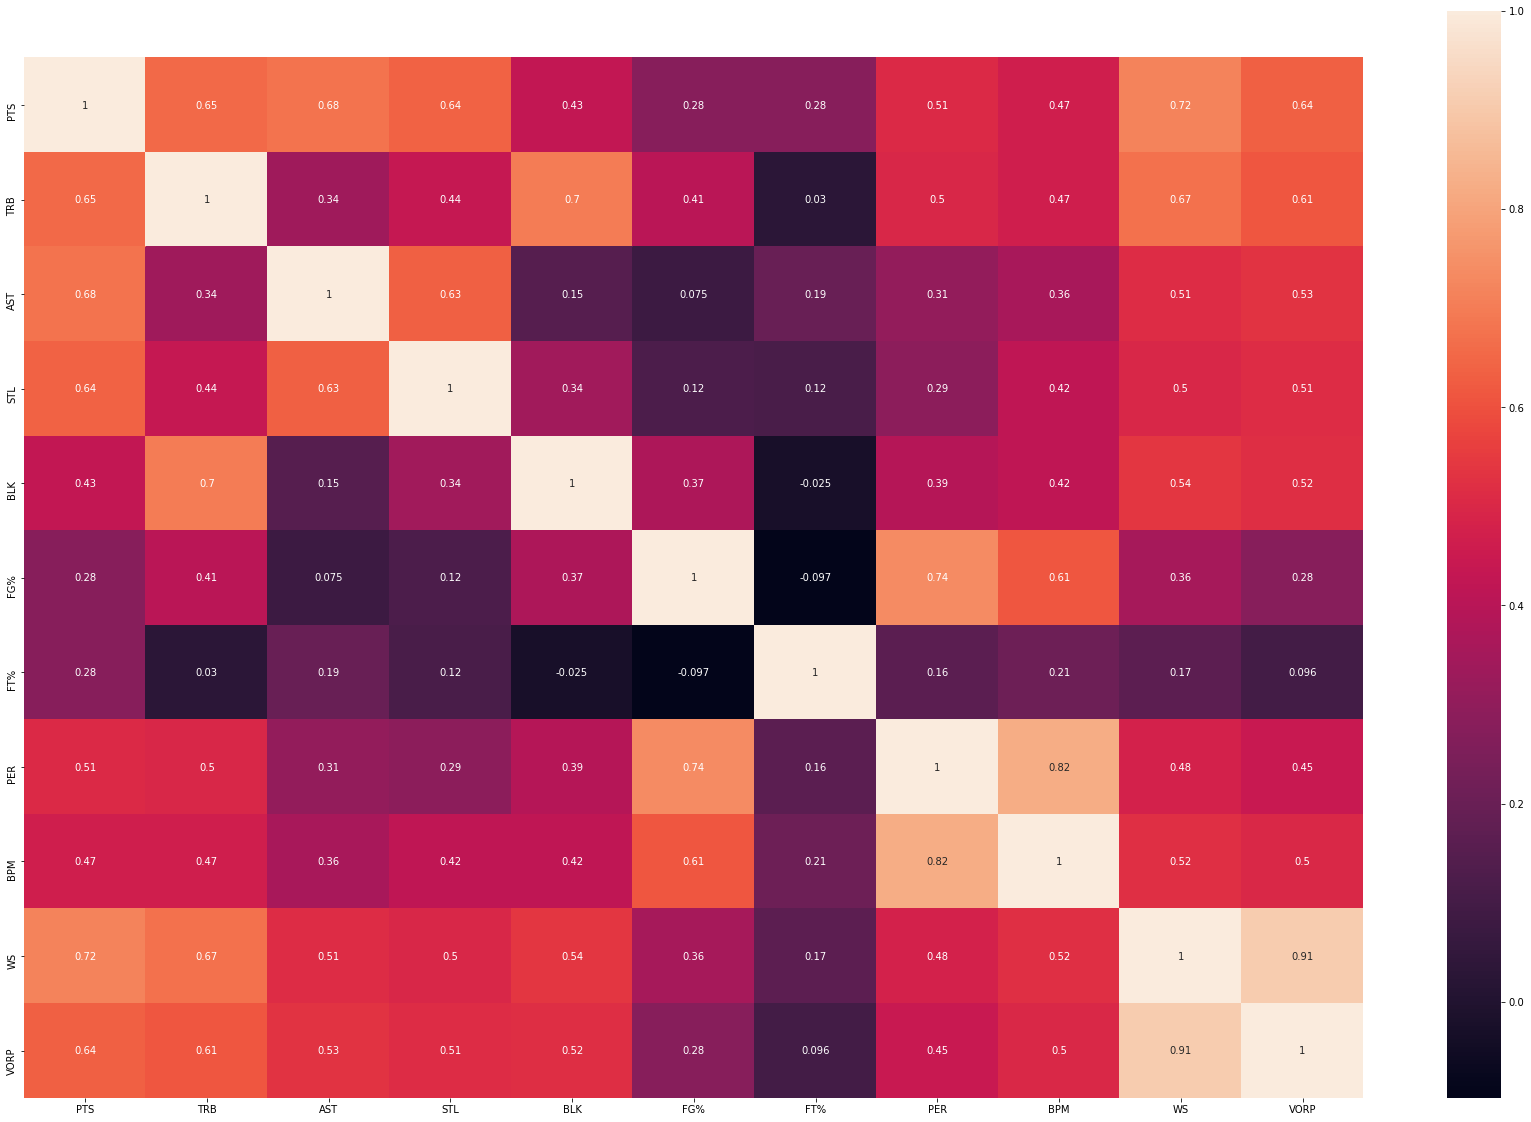

In [29]:
# Using Pearson Correlation
plt.figure(figsize = (30,20))
# Filtering out the stats we used 
data_we_used = nba_stats.filter(['PTS', "TRB", "AST", "STL", "BLK", "FG%", "FT%", 'PER', 'BPM', 'WS', 'VORP'], axis = 1)
# Get the correlation coefficient matrix
cor = data_we_used.corr()
# Create the Heatmap
ax = sns.heatmap(cor, annot = True)
# Prevent the bottom and top of the heatmap from getting cut off
ax.set_ylim(len(cor), -0.5)

plt.show()

When looking at the results of the heatmap we want to find statistics that are not heavily correlated with other statistics in our data. This would mean that we want to use statistics that have darker cells in the heatmap as opposed to cells that have lighter cells in the heatmap. By using this idea we can see that FT% and FG% are not heavily correlated with other statistics and thus should be included in our model. In addition, we can see that the other counting statistics (PTS, TRB, AST, STL, BLK) are less correlated with other statistics than the advanced statistics. This indicates that we should also include these counting stats in our model. When it comes to advanced statistics, BPM and PER are less correlated with other statistics than WS and VORP. Thus, we will include BPM and PER in our model.

<center>
<h1 style="font-size:24px">Creating Test Data</h1>

We will be trying to predict the voting share value from our historical dataset because the player with the highest voting share will be the winner of the MVP award. The voting share is calculated by dividing the voting points won by the maximum amount of points that one could recieve during voting.

In [30]:
# Create training and test data using statistics chosen from heatmap.

# The statistics that we are going to be using to predict voting share 
X = past_mvp_voting[['PTS', "TRB", "AST", "STL", "BLK", "FG%", "FT%", "BPM", "PER"]]
# The voting share target vector
y = past_mvp_voting.Share

# Split into training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

# Only use the statistics that we previously chose
prospective_mvps = prospective_mvps[['PTS', "TRB", "AST", "STL", "BLK", "FG%", "FT%", "BPM", "PER"]]

prospective_mvps

,PTS,TRB,AST,STL,BLK,FG%,FT%,BPM,PER
0,38.0,6.0,7.5,2.0,0.6,0.431,0.879,10.1,31.1
1,30.9,13.2,5.5,1.3,1.3,0.564,0.588,12.6,33.7
2,30.0,9.8,9.2,1.3,0.1,0.476,0.814,13.7,32.1
3,28.8,4.1,8.4,1.3,0.0,0.462,0.860,3.5,23.4
4,28.0,4.5,7.0,1.0,0.2,0.453,0.836,0.5,20.2
5,27.7,9.0,3.3,1.5,2.7,0.507,0.870,7.6,29.8
6,26.7,4.6,7.4,1.0,0.5,0.443,0.911,5.1,24.5
7,26.1,11.7,4.5,1.0,1.4,0.516,0.800,8.8,28.1
8,25.9,6.8,10.8,1.3,0.5,0.501,0.705,9.3,27.3
9,25.5,3.9,6.3,0.6,0.3,0.514,0.908,1.7,19.9


<center>
<h1 style="font-size:28px">Machine Learning Models</h1>

<center>
<h1 style="font-size:24px">Random Forest Regressor</h1>

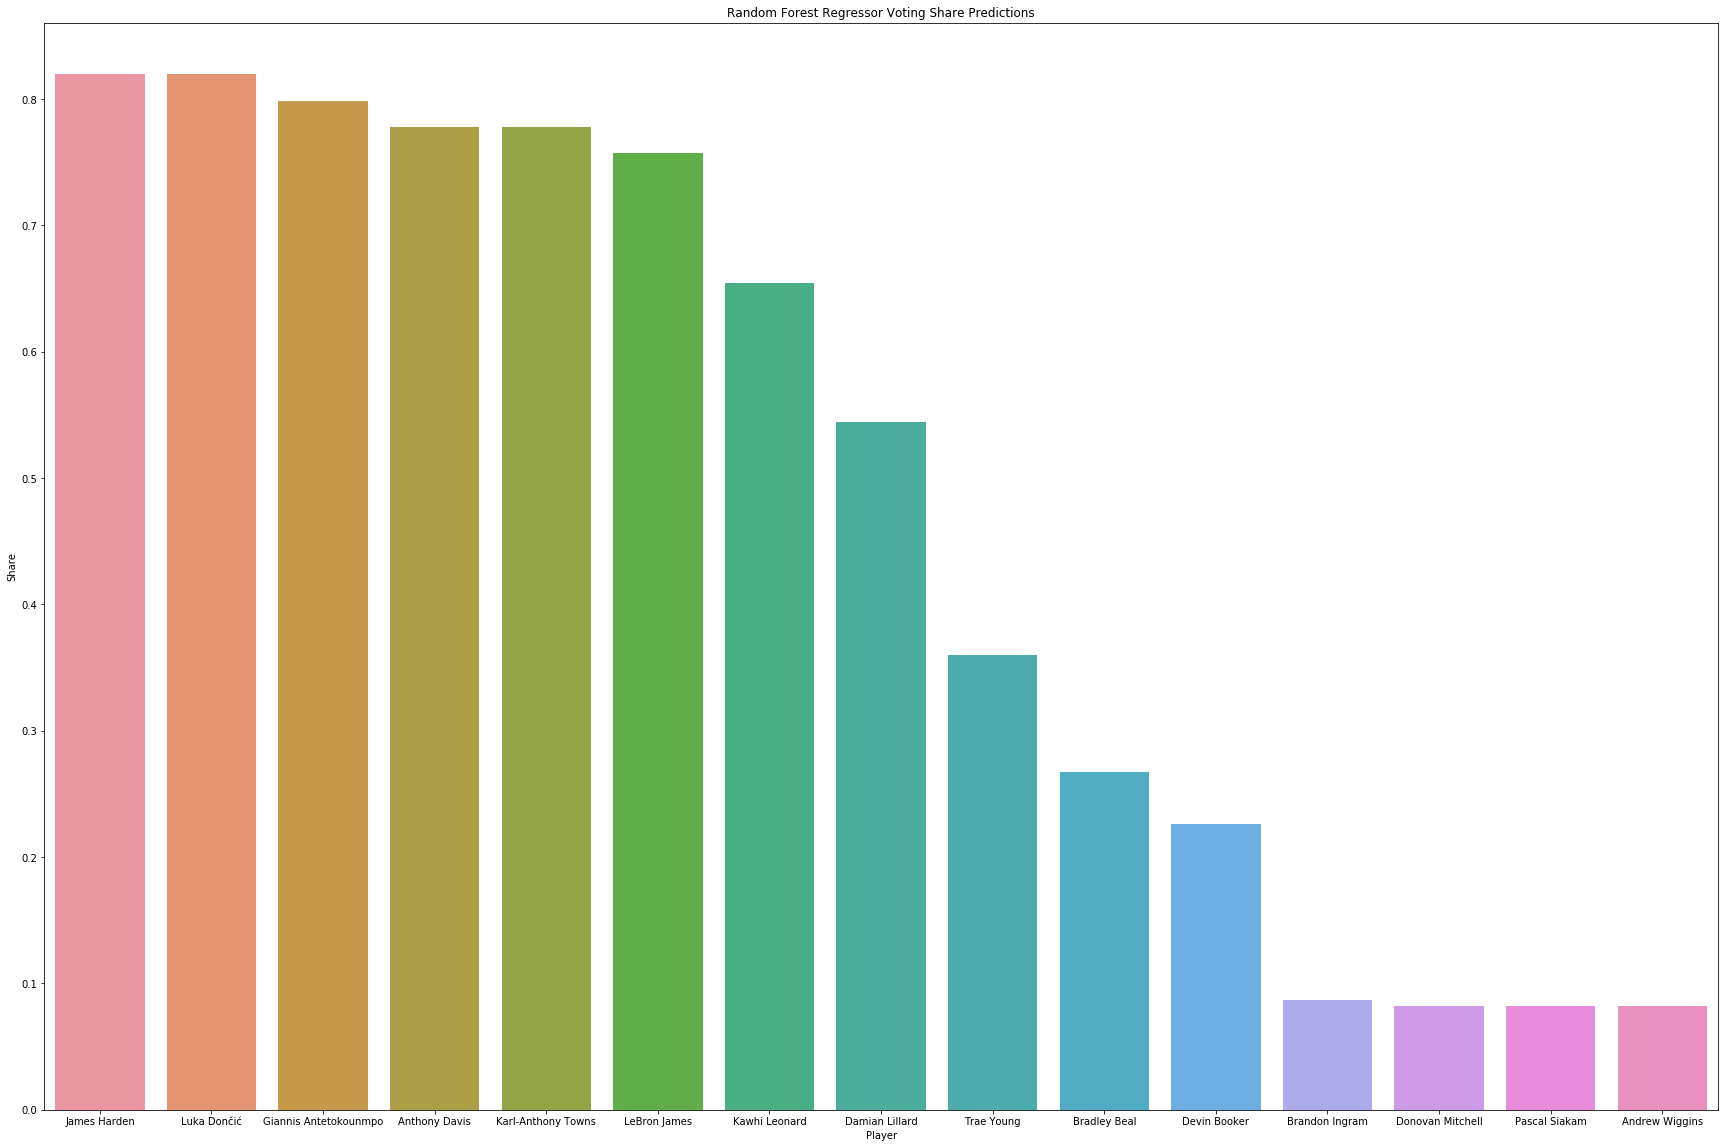

In [31]:
# Random Forest Regressor is created
regr = RandomForestRegressor(n_estimators = 10, max_depth = 2, random_state = 0)
# Fit to our training data
regr.fit(X_train, y_train)

# Predict the voting share
prediction = regr.predict(prospective_mvps)

# Display the results
plt.figure(figsize = (30,20))
results["Share"] = prediction
results = results.sort_values(by = ["Share"], ascending = False)
ax = sns.barplot(x = 'Player', y = 'Share', data = results)
ax.set_title("Random Forest Regressor Voting Share Predictions")
plt.show()

We can see in this graph that when using a Random Forest Regressor model, James Harden and Luka Dočić are tied for the most voting shares with several players trailing behind them at similar voting share. 

<center>
<h1 style="font-size:24px">Decision Tree Regressor</h1>

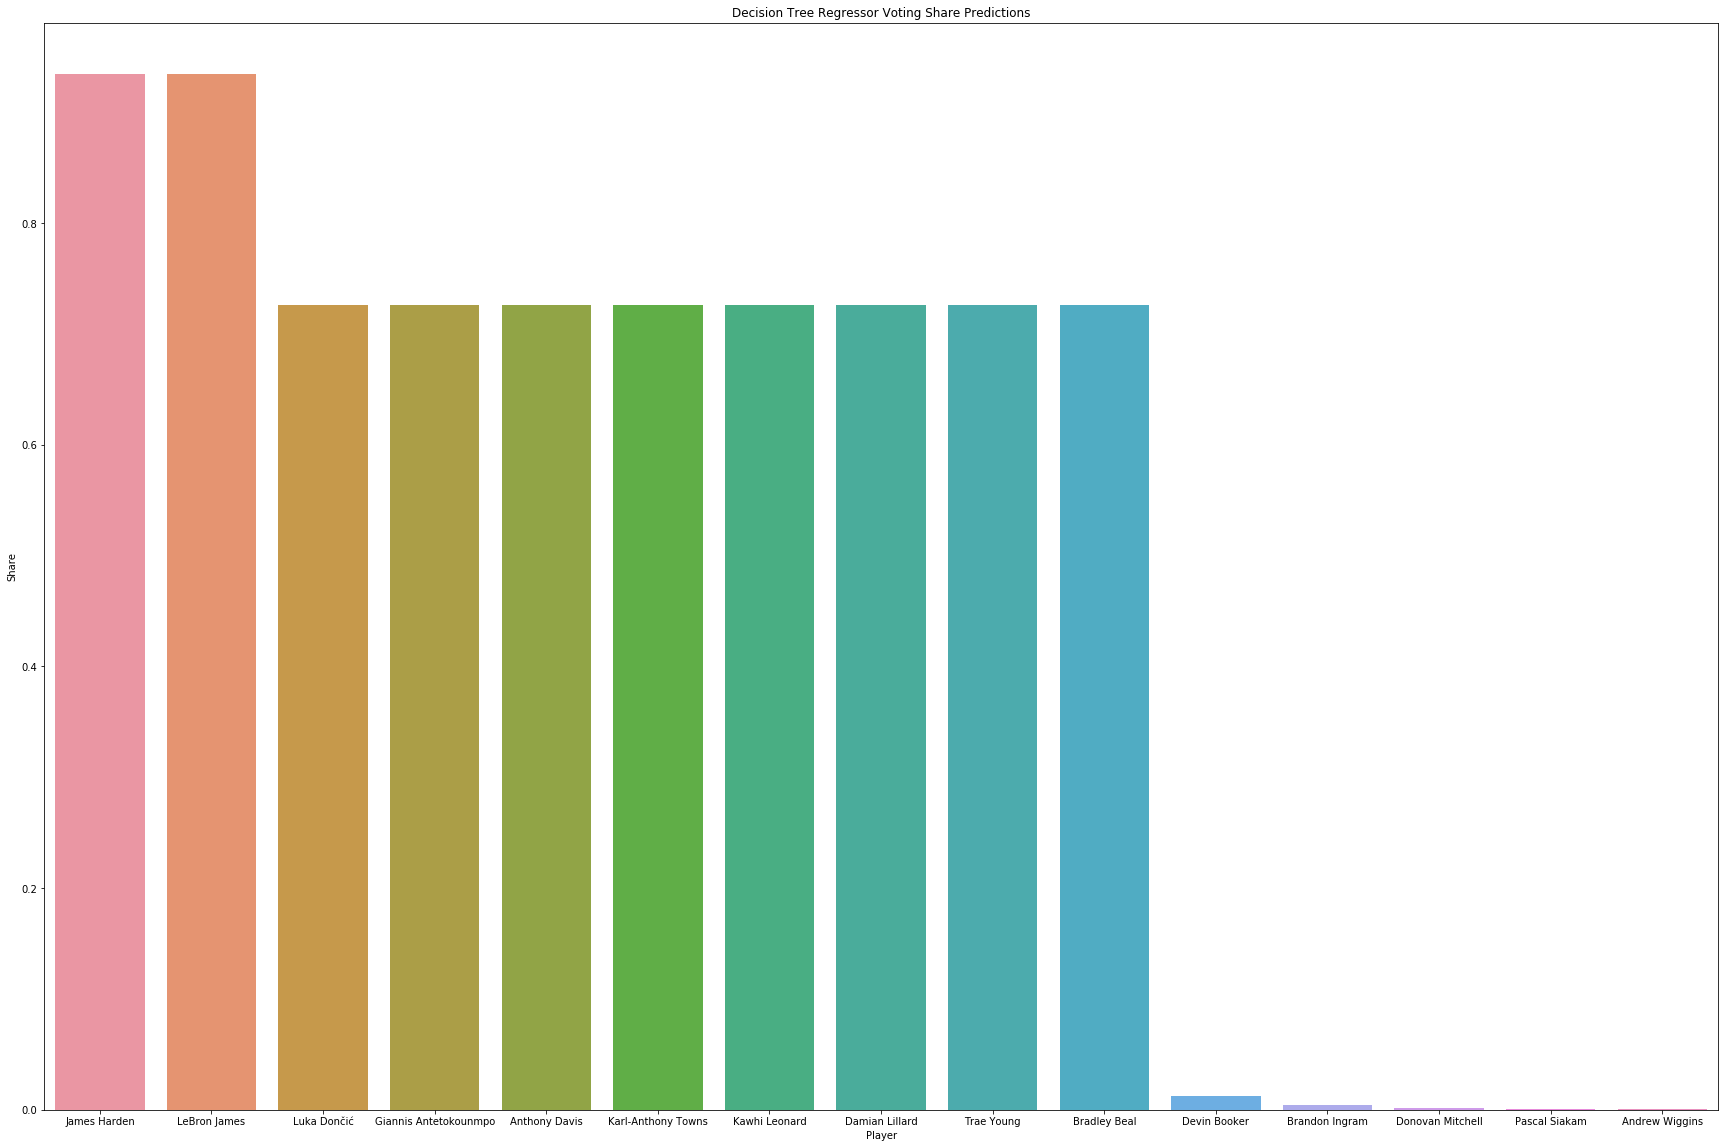

In [32]:
# Create the DecisionTreeRegression 
regressor = DecisionTreeRegressor(random_state = 10)
regressor.fit(X_train, y_train)

# Predict the voting share
prediction = regressor.predict(prospective_mvps)

# Plot the results
plt.figure(figsize = (30,20))
results["Share"] = prediction
results = results.sort_values(by = ["Share"], ascending = False)
ax = sns.barplot(x = 'Player', y = 'Share', data = results)
ax.set_title("Decision Tree Regressor Voting Share Predictions")
plt.show()

We can see in this graph that by using a Decision Tree Regressor model, James Harden and Damian Lillard are tied in voting shares with several players that all have the same voting share trailing behind.

<center>
<h1 style="font-size:24px">Linear Regressor</h1>

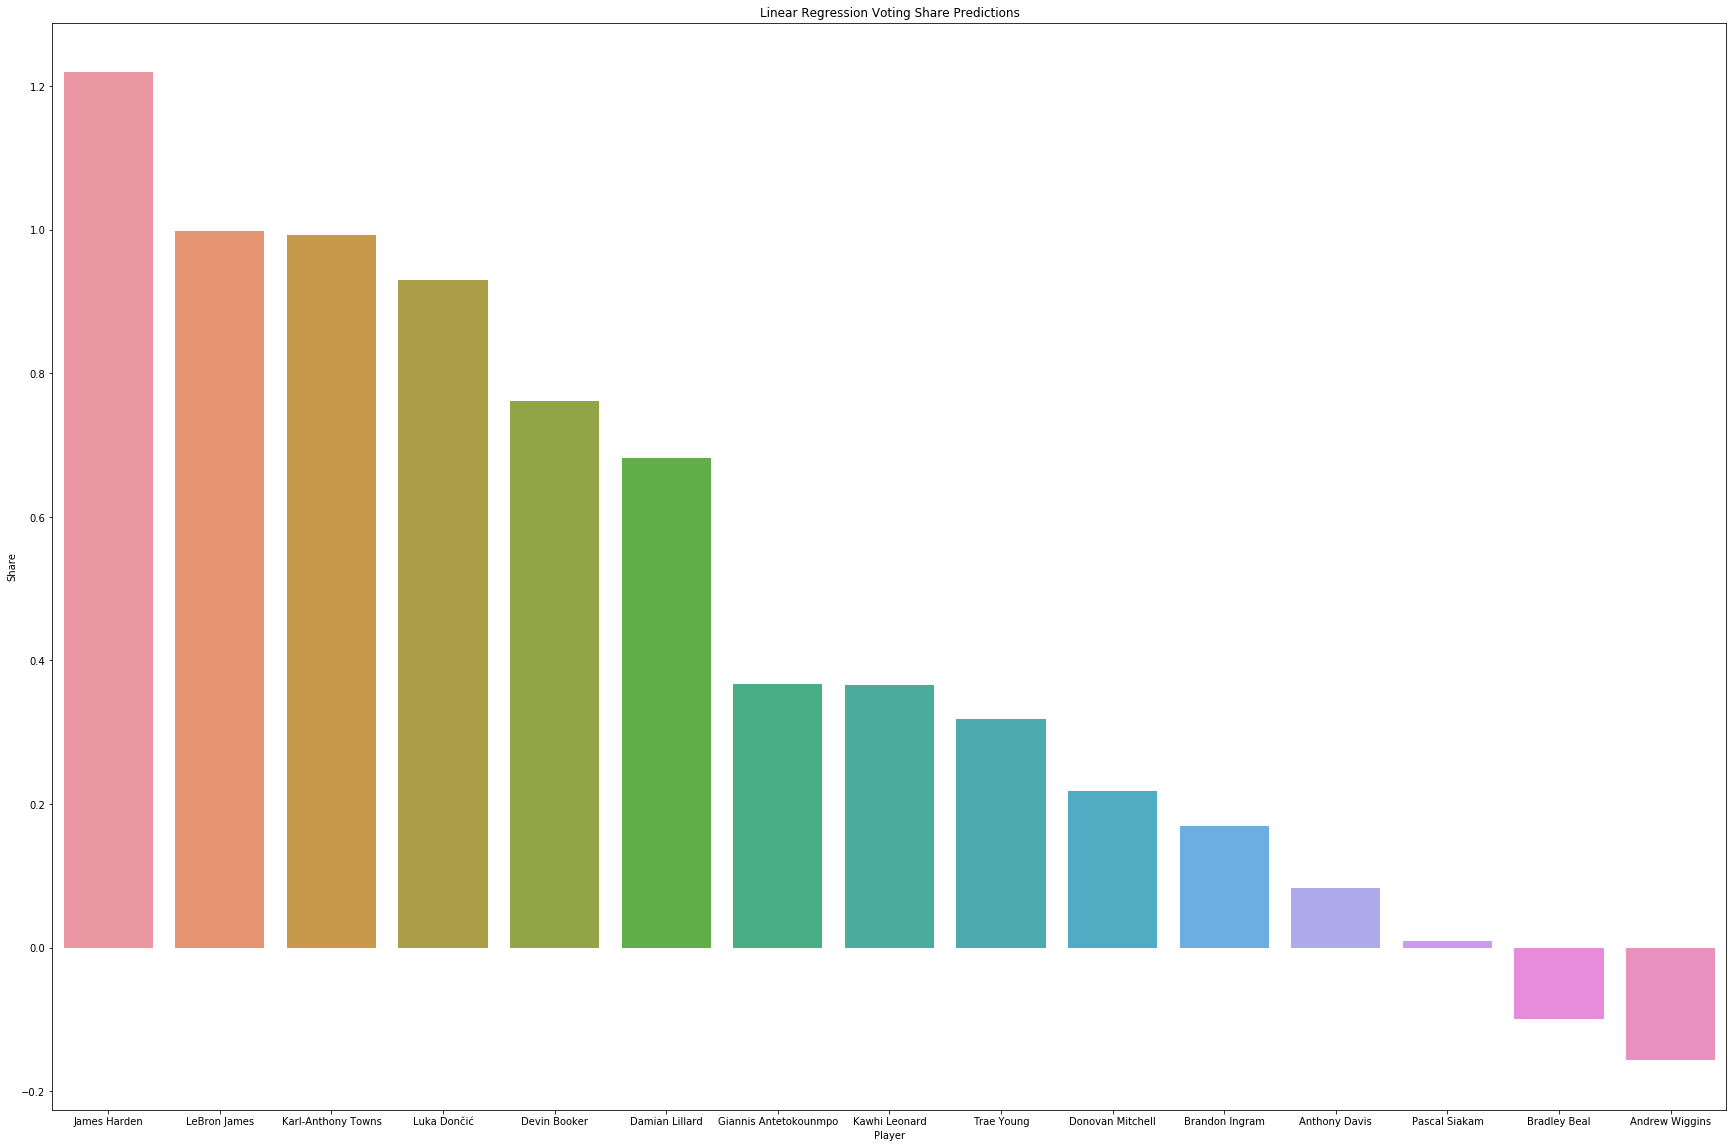

In [33]:
# Create the Linear Regressor
reg = LinearRegression().fit(X, y)
# Fit to our training data
reg.fit(X_train, y_train)

# Predict the voting shares
prediction = reg.predict(prospective_mvps)

# Plot the results
plt.figure(figsize = (30,20))
prediction = reg.predict(prospective_mvps)
results["Share"] = prediction
results = results.sort_values(by = ["Share"], ascending = False)
ax = sns.barplot(x = 'Player', y = 'Share', data = results)
ax.set_title("Linear Regression Voting Share Predictions")
plt.show()

When we use a Linear Regression model we can see that James Harden has a considerable lead in voting shares.

So, if we look at the results of all three of our models we can see that James Harden is leading or tied for the lead in every prediction, therefore our models predicted that the 2019-2020 NBA MVP will be James Harden.
<p><img src="files/figs/james_cooking.gif" alt="animated"></p>


<center>
<h1 style="font-size:28px">Conclusions</h1>

Based on our analysis, there are multiple counting and advanced statistics that are important to take into account when trying to predict the winner of the MVP award. We found that the key statistics are:
<ul>
<li>Points Per Game</li>
<li>Total Rebounds Per Game</li>
<li>Assists Per Game</li>
<li>Steals Per Game</li>
<li>Blocks Per Game</li>
<li>Field Goal Percentage</li>
<li>Free Throw Percentage</li>
<li>Box Plus/Minus</li>
<li>Player Efficiency Rating</li>    
</ul>



According to our model, James Harden is the leading candidate for the MVP award this season; however, the season is still ongoing. Our dataset was last updated on 12/10/2019, which is quite early in the season. Anything could happen during the remainder of the season to impact future data that would be used for the model, such as injuries or trades.

The logic behind our model can be extrapolated for other awards such as Rookie of the Year. A model to predict Rookie of the Year would factor in the most important counting and advanced statistics for the award, just like we did for MVP. We believe that the key statistics to select the MVP and ROY are similar enough that a few tweaks to our model would make it possible to predict the ROY front-runner.